In [1]:
cd C:\Users\ciiad\연구

C:\Users\ciiad\연구


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
warnings.filterwarnings(action='ignore') 
from dateutil.relativedelta import relativedelta

In [3]:
### 이전 년도의 date quarter 를 계산하는 함수 ###
previous_period = lambda P : pd.Period(str(P.year-1) + 'Q4') if P < pd.Period('2000Q4') else pd.Period(str(P.year-1) + 'Q'+str(P.quarter))
### 결산월 전처리 ###
preprocessing_period = lambda path_period : pd.read_csv(path_period,index_col = 0, parse_dates=['Symbol']).fillna(method = 'ffill').fillna(method = 'bfill').fillna(12)

def preprocessing_mktdata(path_mkt_data) :    
    ############################
    ## 시가총액 데이터 전처리 ##
    ############################
    mkt_data = pd.DataFrame([])
    for i in pd.read_csv(path_mkt_data , index_col = 0, chunksize = 12000, engine = 'python') :
        mkt_data = pd.concat([mkt_data, i], axis = 0)
    
    Common = mkt_data[mkt_data.columns[::2]].iloc[1:].applymap(lambda x : x.replace(',','') if type(x) == str else x).astype(np.float64)
    Prefer = mkt_data[mkt_data.columns[1::2]].iloc[1:].applymap(lambda x : x.replace(',','') if type(x) == str else x).astype(np.float64)
    
    mkt_data = pd.DataFrame(np.array(Common)/100 + np.array(Prefer.fillna(0))/100, columns = Common.columns, index = Common.index)
    mkt_data.index = pd.to_datetime(mkt_data.index)
    return mkt_data.resample('D').last().fillna(method = 'ffill', limit = 10)

def preprocessing_price(path_price) : 
    ########################
    ## 가격 데이터 전처리 ##
    ########################
    price_data = pd.DataFrame([])
    for i in pd.read_csv(path_price ,index_col = 0, chunksize = 6000, engine = 'python') :
        price_data = pd.concat([price_data, i], axis = 0)        
    price_data = price_data.applymap(lambda x : x.replace(',','') if type(x) == str else x ).astype(np.float64)
    price_data.index = pd.to_datetime(price_data.index)
    return price_data.resample('D').last().fillna(method = 'ffill', limit = 10)

def preprocessing_kospiyn(path_kospiyn, mkt='유가증권시장') :
    ##########################################
    ### 거래소(코스피,코스닥)데이터 전처리  ##
    #########################################
    data = pd.DataFrame([])
    for i in pd.read_csv(path_kospiyn, index_col = 0 , chunksize = 6000 , engine = 'python') :
        data = pd.concat([data,i], axis = 0)
    data.index = pd.to_datetime(data.index)
    if mkt == '유가증권시장' or mkt == '코스닥':
        data = data.astype(str).applymap(lambda x : int(mkt in x)).resample('D').last()
    elif mkt == 'both' :
        data = data.astype(str).applymap(lambda x : int('유가증권시장' in x or '코스닥' in x)).resample('D').last()
    data = data.fillna(method = 'ffill', limit = 10)
    return data

def remove_lookahead_bias(stock_index ,Day, cleaned_period) :
    #######################################################################################################################
    ## 결산월이 1,2,4,5,7,8,10,11 제거하기 및 3,6,9월이면 해당 시점에 재무 데이터가 존재하는지 확인하고 없으면 종목 제거 ##
    #######################################################################################################################    
    not_12 = cleaned_period[stock_index][:Day].iloc[-1][cleaned_period[stock_index][:Day].iloc[-1] != 12]
    not_12 = not_12[not_12.apply(lambda x : x in [3,6,9])]    
    Day = pd.to_datetime(Day)
    temp_lst = (datetime.datetime(Day.year,4,1) , datetime.datetime(Day.year,5,15),
                datetime.datetime(Day.year,8,16) , datetime.datetime(Day.year,11,16))

    if Day >= temp_lst[0] and Day < temp_lst[1] :
        reference_date = datetime.datetime(Day.year-1, 12, 31)
    elif Day >= temp_lst[1] and Day < temp_lst[2] :
        reference_date = datetime.datetime(Day.year, 3, 31)
    elif Day >= temp_lst[2] and Day < temp_lst[3] :
        reference_date = datetime.datetime(Day.year, 6, 30)
    else :
        reference_date = datetime.datetime(Day.year-1, 9, 30)
    end_months = reference_date.month
    index_name = not_12[not_12 ==end_months].index
    if (Day - reference_date).days < 91 :
        stock_index = stock_index.difference(index_name)
    return stock_index

def preprocessing_data(path_data) :
    #############################
    ## 재무 데이터 전처리 함수 ##
    #############################
    data = pd.read_csv(path_data, index_col = [0], header = [0,1]).astype(np.float64)
    data.columns = [pd.MultiIndex.droplevel(data.columns, level = 1),pd.to_datetime(pd.MultiIndex.droplevel(data.columns, level = 0)).to_period('Q')]    
    name_lst = ['총자산','총부채','총자본','무형자산','자기주식']
    for name in name_lst : # 일부 데이터 조정
        a = data[name][data[name].columns[:59]]
        b = data[name][data[name].columns[59:63]].fillna(method = 'ffill',axis=1)
        c = data[name][data[name].columns[63:]]
        d = pd.concat([a,b,c],axis = 1)
        data[name] = d    
    return data

def preprocessing_Created_Factor(path_Created_Factor) :
    ###################################
    ## FF3 Factor 데이터 전처리 함수 ##
    ###################################    
    try :
        data = pd.read_csv(path_Created_Factor, index_col = 0 , engine = 'python', encoding = 'utf-8')
    except :
        data = pd.read_csv(path_Created_Factor, index_col = 0 , engine = 'python')
    data.index = pd.to_datetime(data.index)
    data['금리'] = data['금리']/100
    start_index = data['small_highbm'].dropna().index[0]
    initial_money = int(data['small_highbm'].dropna().iloc[0])
    Small = (initial_money * (1+data[['small_highbm','small_mediumbm','small_highbm']].pct_change().mean(1)[start_index:].fillna(0)).cumprod(0)).astype(int)
    Big = (initial_money * (1+data[['big_highbm','big_mediumbm','big_highbm']].pct_change().mean(1)[start_index:].fillna(0)).cumprod(0)).astype(int)
    HighBM = (initial_money * (1+data[['small_highbm','big_highbm']].pct_change().mean(1)[start_index:].fillna(0)).cumprod(0)).astype(int)
    LowBM = (initial_money * (1+data[['small_lowbm','big_lowbm']].pct_change().mean(1)[start_index:].fillna(0)).cumprod(0)).astype(int)    
    data['Small_Size'], data['Big_Size'],data['High_BM'],data['Low_BM'] = Small  , Big, HighBM, LowBM    
    return data.astype(np.float64)

def preprocessing_stop_and_delist(path_delist) :
    #########################################
    ## 거래정지 및 상장폐지 데이터 전처리  ##
    #########################################    
    data = pd.DataFrame([])
    for i in pd.read_csv(path_delist, index_col = 0 , chunksize = 6000, engine = 'python') :
        data = pd.concat([data,i], axis = 0)
    delist_data = data[[data.columns[1]]].iloc[1:]
    delist_data = delist_data[delist_data['상장폐지일자'].isna() == False]
    delist_data['상장폐지일자'] = delist_data['상장폐지일자'].apply(lambda x : pd.to_datetime(x))
    small_col = list(data[data.columns[2:]].iloc[0])
    small_col = pd.to_datetime(small_col)
    big_col = pd.Series(data.columns[2:]).apply(lambda x : x.split('.')[0])    
    stop_data = data[data.columns[2:]].iloc[1:]
    stop_data.columns = [big_col,small_col]
    stop_data = stop_data.applymap(lambda x : 1 if x in ['TRUE' , True] else 0)        
    return  delist_data, stop_data

def preprocessing_price_adjust_delist(delist_data, cleaned_price) :
    ##########################################
    ## 상장 폐지 이후 가격을 0으로 만들어줌 ##
    ##########################################
    cleaned_price2 = cleaned_price
    for i in delist_data.index :
        delist_day = delist_data['상장폐지일자'].loc[i]
        price = cleaned_price2[[i]]
        traded_date = price[price[i].isna() == False].index
        if len(traded_date) > 0 :
            price[traded_date[-1]:][i].iloc[1:] = 0
            cleaned_price2[i] = price[i]
    return cleaned_price2

def preprocessing_Datas_adj_irregular(cleaned_data, cleaned_price, cleaned_mktvalue, delist_data, stop_data) :
    ###############################
    ###### 노이즈 데이터 제거 #####
    ###############################
    PRICE = preprocessing_price_adjust_delist(delist_data, cleaned_price)
    irregular = (PRICE.pct_change() >= 8).sum(0) ## 하룻동안 수익률이 8이상 인 것을 제거
    irregular_index = irregular[irregular>0].index
    PRICE = PRICE[PRICE.columns.difference(irregular_index)]
    STOP= stop_data['거래정지여부'].loc[stop_data.index.difference(irregular_index)].T
    STOP = STOP.resample('D').last().fillna(method = 'ffill', limit = 10)
    DELIST = delist_data.loc[delist_data.index.difference(irregular_index)]
    FINANCE = cleaned_data.loc[cleaned_data.index.difference(irregular_index)]
    PRICE = PRICE.resample('D').last().fillna(method = 'ffill', limit = 10)
    MKT_VALUE = cleaned_mktvalue[cleaned_mktvalue.columns.difference(irregular_index)]
    MKT_VALUE = MKT_VALUE.resample('D').last().fillna(method = 'ffill', limit = 10)
    return PRICE, FINANCE, STOP, DELIST, MKT_VALUE

def equal_weighted_series(choosed_name, MKT_VALUE, day,largest_w = '') :
    return pd.Series([1/len(choosed_name)] * len(choosed_name), index= choosed_name).T

def mkt_weight_series(choosed_name, MKT_VALUE, day , largest_w = 0.1) :  
    ##############################
    ### Value Weight Function  ###
    ##############################
    if len(choosed_name) > 15 : 
        w = MKT_VALUE[choosed_name].loc[:day].iloc[-1].fillna(0) / MKT_VALUE[choosed_name].loc[:day].iloc[-1].sum()
        new_w = w+0
        break_number = 0
        while new_w.max() > largest_w :
            extra_w = (new_w[new_w>largest_w] - largest_w).sum()
            n = (new_w<=largest_w).sum()
            add_w = (new_w<=largest_w) * extra_w/n
            new_w = np.minimum(largest_w , new_w) + add_w    
            break_number +=1
            if break_number >=10 :
                break
        return new_w
    else :
        w = pd.Series([1/len(choosed_name)]*len(choosed_name),index = choosed_name)
        return w
    
def make_beta_df(cleaned_price, Created_Factor, last_day = '2020-09-30') :
    #############################
    ## 각 종목의 Beta값을 구함 ##
    #############################
    name_index = cleaned_price.columns
    RETURN, RETURN_MKT = cleaned_price.resample('M').last().pct_change() , Created_Factor['코스피'].resample('M').last().pct_change()
    r = Created_Factor['금리'].resample('M').last()
    rdt = r.shift(1) * pd.Series(r.index,index= r.index).diff().apply(lambda x : x.days)/365
    RET_MKT,beta_df,x = RETURN_MKT - rdt,pd.DataFrame([]),0
    for name in name_index :
        x = x + 1
        RET = RETURN[name] - rdt
        beta_data = pd.DataFrame([],index = [name])
        for n in pd.date_range('1983-03-31', last_day, freq = 'Q') :
            start_day = n - relativedelta(years = 5)
            YX = pd.DataFrame(RET[start_day:n])
            YX['constant'] = 1
            YX['RET_M'] = RET_MKT[start_day:n]
            yx = YX.dropna()
            if len(yx) > 35 : 
                beta = sm.OLS(yx[yx.columns[0]] , yx[yx.columns[1:]]).fit().params.iloc[1]
                beta_data[pd.Period(n, freq = 'Q')] = beta
            else : 
                beta_data[pd.Period(n, freq = 'Q')] = np.nan
        print(x)
        beta_df = pd.concat([beta_df,beta_data] , axis = 0)
    beta_df.to_excel('beta_data.xlsx')
    return beta_df    

def finance_data_plus_beta(beta_path, cleaned_data) :
    beta_df = pd.read_excel(beta_path,index_col = 0)
    small_col = list(pd.Series(beta_df.columns).apply(pd.Period))
    big_col = ['베타']*len(small_col)
    beta = beta_df.copy()
    beta.columns = [big_col, small_col]
    try : 
        cleaned_data = cleaned_data.drop(['베타'],axis = 1)
        cleaned_data = pd.concat([cleaned_data,beta],axis = 1)
    except :
        cleaned_data = pd.concat([cleaned_data,beta],axis = 1)
    return cleaned_data

def Idiosyncratic_Risk(cleaned_price, Created_Factor,last_day =  '2020-09-30') :
    ###################################
    ### 기업 잔차 수익률을 계산한다 ###
    ###################################
    name_index,resid_df,x = cleaned_price.columns ,pd.DataFrame([]),0
    RETURN = cleaned_price.resample('M').last().pct_change()
    RETURN_MKT = Created_Factor['코스피'].resample('M').last().pct_change()
    SMB = Created_Factor['Small_Size'].resample('M').last().pct_change() - Created_Factor['Big_Size'].resample('M').last().pct_change()
    HML = Created_Factor['High_BM'].resample('M').last().pct_change() - Created_Factor['Low_BM'].resample('M').last().pct_change()
    r = Created_Factor['금리'].resample('M').last()
    rdt = r.shift(1) * pd.Series(r.index,index= r.index).diff().apply(lambda x : x.days)/365
    for name in name_index :
        x +=1
        RET_MKT = RETURN_MKT - rdt
        RET = RETURN[name] - rdt
        resid_series = pd.Series([])
        for n in pd.date_range('1983-03-31', last_day, freq = 'Q') :
            YX = pd.DataFrame(RET[n - relativedelta(years = 5) :n])
            YX['constant'] = 1
            YX['MKT'] = RET_MKT[n - relativedelta(years = 5) :n]
            YX['SMB'] = SMB[n - relativedelta(years = 5) :n]
            YX['HML'] = HML[n - relativedelta(years = 5) :n]
            YX = YX.dropna()
            if len(YX) > 6 :
                resid = sm.OLS(YX[YX.columns[0]], YX[['constant','MKT','SMB','HML']]).fit().resid
                resid_series = resid_series.append(resid.loc[resid.index.difference(resid_series.index)])
            else :
                resid = pd.Series(index = Created_Factor.resample('M').last()[n - relativedelta(years = 5) :n].index)
                resid_series = resid_series.append(resid.loc[resid.index.difference(resid_series.index)])
        resid_series = resid_series.rename(name)
        resid_df = pd.concat([resid_df, resid_series], axis = 1)   
        print(x)
    res_df.to_excel('Idiosyncratic_Return.xlsx')
    return resid_df

def calculate_data_quarter(start_day) :
    ###############################################
    ### 정기공시 발표 날짜에 맞춰서 데이터 사용 ###
    ###############################################
    start_day = pd.to_datetime(start_day)
    if pd.to_datetime(start_day) > pd.to_datetime('2000-03-31') :
        temp_lst = datetime.datetime(start_day.year,5,1) , datetime.datetime(start_day.year,6,15),datetime.datetime(start_day.year,9,15) , datetime.datetime(start_day.year,12,15)
        if  start_day < temp_lst[0] :
            data_quarter = str(start_day.year - 1)[-4:] +  'Q3'
        elif start_day >= temp_lst[0] and start_day < temp_lst[1] :
            data_quarter = str(start_day.year - 1)[-4:] +  'Q4'
        elif start_day >= temp_lst[1] and start_day < temp_lst[2] :
            data_quarter = str(start_day.year)[-4:]  + 'Q1'
        elif start_day >= temp_lst[2] and start_day < temp_lst[3] :
            data_quarter = str(start_day.year)[-4:]  + 'Q2'
        else :
            data_quarter = str(start_day.year)[-4:]  + 'Q3'
    else :
        if pd.to_datetime(start_day) >= datetime.datetime(start_day.year, 5,1) :
            data_quarter = str(start_day.year - 1)[-4:]  + 'Q4'    
        elif pd.to_datetime(start_day) < datetime.datetime(start_day.year, 5,1) :
            data_quarter = str(start_day.year - 2)[-4:]  + 'Q4'
    return data_quarter

def next_rebalance_date(day) :
    ####################################
    ### 가장 빠른 차기 리벨런싱 날짜 ###
    ####################################
    day = pd.to_datetime(day)
    if day.year > 2000 : 
        if day < datetime.datetime(day.year , 5,1) :
            next_endtime = datetime.datetime(day.year, 5, 1)
        elif day < datetime.datetime(day.year, 6,16) and day >= datetime.datetime(day.year, 5,1) :
            next_endtime = datetime.datetime(day.year, 6,16)
        elif day < datetime.datetime(day.year, 9,16) and day >= datetime.datetime(day.year, 6,16) :
            next_endtime = datetime.datetime(day.year, 9,16)
        elif day < datetime.datetime(day.year, 12,16) and day >= datetime.datetime(day.year, 9,16) :
            next_endtime = datetime.datetime(day.year, 12,16)
        else :
            next_endtime = datetime.datetime(day.year +1, 5, 1)
    else :
        if day < datetime.datetime(day.year , 6,1) :
            next_endtime = datetime.datetime(day.year, 6,1)
        elif day < datetime.datetime(day.year,12,1) and day >= datetime.datetime(day.year, 6,1) :
            next_endtime = datetime.datetime(day.year, 12, 1)
        else :
            next_endtime = datetime.datetime(day.year + 1, 6,1)
    return next_endtime

def Calculate_PXR(cleaned_data , cleaned_mktvalue, today, data_Q, X = '당기순이익') :
    data_Q = pd.Period(data_Q)
    mktvalue = cleaned_mktvalue[:today].iloc[-2]
    E = cleaned_data[X][data_Q]
    PXR = (mktvalue/E)
    POSITIVE_PXR = PXR[PXR>0]
    return POSITIVE_PXR
def Calculate_PBR(cleaned_data , cleaned_mktvalue, today, data_Q) :
    data_Q = pd.Period(data_Q)    
    mktvalue = cleaned_mktvalue[:today].iloc[-2]
    B = cleaned_data['총자본'][data_Q] -cleaned_data['무형자산'][data_Q].fillna(0) + cleaned_data['자기주식'][data_Q].fillna(0)
    PXR = (mktvalue/B)
    POSITIVE_PXR = PXR[PXR>0]
    return POSITIVE_PXR
def Sorted_PXR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), X = '당기순이익') :
    index = cleaned_mktvalue[:today].iloc[-1][cleaned_mktvalue[:today].iloc[-1]>0].index
    PXR_data = Calculate_PXR(cleaned_data.loc[index], cleaned_mktvalue[index], today, data_Q, X)
    n1 = int(len(PXR_data) * quantile[0])
    n2 = int(len(PXR_data) * quantile[1])
    sorted_PXR_index = PXR_data.sort_values().index
    return cleaned_data.loc[sorted_PXR_index].iloc[n1:n2]
def size_option_fun(cleaned_mktvalue, day, size_option, result_data) :
    if type(size_option) != str :
        return result_data
    else :
        if size_option.lower() == 'small' :
            mkt = cleaned_mktvalue[:pd.to_datetime(day)].iloc[-1]
            median = mkt.median()
            index =  mkt[mkt<median].index
            return result_data.loc[result_data.index.intersection(index)]
        else  :
            mkt = cleaned_mktvalue[:pd.to_datetime(day)].iloc[-1]
            median = mkt.median()
            index =  mkt[mkt>=median].index
            return result_data.loc[result_data.index.intersection(index)]

In [4]:
path_mkt_data = '코스피시총데이터.csv'
path_price = '코스피주가데이터.csv'
path_delist = '코스피상장폐지데이터.csv'
path_data = 'cleaned_data2.csv'
path_period = '코스피결산월.csv'
path_FF3 = 'Calibrated_FF3.csv'
path_kospiyn = '코스피거래소데이터.csv'

In [5]:
cleaned_price = preprocessing_price(path_price)
Created_Factor = preprocessing_Created_Factor(path_FF3)

In [6]:
cleaned_data = preprocessing_data(path_data)
cleaned_mktvalue = preprocessing_mktdata(path_mkt_data)
delist_data, stop_data = preprocessing_stop_and_delist(path_delist)
cleaned_kospiyn = preprocessing_kospiyn(path_kospiyn,mkt='유가증권시장')
cleaned_period = preprocessing_period(path_period)
cleaned_residual = pd.read_excel('Idiosyncratic_Return.xlsx',index_col = 0)

In [7]:
class Value :
    def PER(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        result_data =  Sorted_PXR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile , X = '당기순이익')
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
    def PBR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3),cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        index = cleaned_mktvalue[:today].iloc[-1][cleaned_mktvalue[:today].iloc[-1]>0].index
        PBR_data = Calculate_PBR(cleaned_data , cleaned_mktvalue, today, data_Q)
        n1 = int(len(PBR_data) * quantile[0])
        n2 = int(len(PBR_data) * quantile[1])
        sorted_PBR_index = PBR_data.sort_values().index    
        result_data =  cleaned_data.loc[sorted_PBR_index].iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
        
    def PSR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3),cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        result_data = Sorted_PXR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile , X = '매출액')
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
    
    def PCR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3),cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        result_data = Sorted_PXR(cleaned_data, cleaned_mktvalue, today, data_Q,quantile , X = '영업활동으로인한현금흐름')
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
        
    def BLEND(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3),cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        PER_RANK = Calculate_PXR(cleaned_data , cleaned_mktvalue, today, data_Q, X = '당기순이익').rank()
        PBR_RANK = Calculate_PBR(cleaned_data , cleaned_mktvalue, today, data_Q).rank()
        PSR_RANK = Calculate_PXR(cleaned_data, cleaned_mktvalue, today , data_Q,X = '매출액').rank()
        PCR_RANK = Calculate_PXR(cleaned_data, cleaned_mktvalue, today , data_Q,X = '영업활동으로인한현금흐름').rank()
        my_data = cleaned_data
        my_data['PER_RANK'],my_data['PBR_RANK'] = PER_RANK,PBR_RANK
        my_data['PSR_RANK'],my_data['PCR_RANK'] = PSR_RANK, PCR_RANK
        TOTAL_RANK1 = my_data[my_data['PCR_RANK']>0][['PER_RANK','PBR_RANK','PSR_RANK','PCR_RANK']].mean(1, skipna = False)
        TOTAL_RANK2 = my_data[my_data['PCR_RANK'].isna()][['PER_RANK','PBR_RANK','PSR_RANK']].mean(1, skipna = False)
        TOTAL_RANK = TOTAL_RANK1.append(TOTAL_RANK2).dropna().rank()
        my_data['TOTAL_RANK'] = TOTAL_RANK
        result = my_data.sort_values(by = ['TOTAL_RANK'])
        result = result.loc[result['TOTAL_RANK'].dropna().index]
        n1 = int(quantile[0] * len(result))
        n2 = int(quantile[1] * len(result))
        result_data = result.iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)        
    
    def EV_EBITDA(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        my_data = cleaned_data
        EV = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days = 1)].iloc[-1] + cleaned_data['총부채'][data_Q]
        EBITDA = cleaned_data['EBITDA'][data_Q]
        EVEBITDA = EV/EBITDA
        my_data['EVEBITDA'] = EVEBITDA[EVEBITDA>0]
        index = my_data['EVEBITDA'].dropna().index
        n1 = int(len(index) * quantile[0])
        n2 = int(len(index) * quantile[1])    
        result_data = my_data.loc[index].sort_values(by = ['EVEBITDA']).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    
    
class Quality :

    def Gross_Profitability(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        Gross_Profit = (cleaned_data['매출총이익'][data_Q] / cleaned_data['매출액'][data_Q])
        Gross_Profit = Gross_Profit[Gross_Profit != 1].dropna()
        my_data = cleaned_data.loc[Gross_Profit.index]
        my_data['Gross_Profit'] = Gross_Profit
        n1 = int(len(my_data) * quantile[0])
        n2 = int(len(my_data) * quantile[1])
        result_data = my_data.sort_values(by = ['Gross_Profit'], ascending = False).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)

    def Operation_Profitability(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        Operation_Profit = (cleaned_data['영업이익'][data_Q] / cleaned_data['매출액'][data_Q])
        Operation_Profit = Operation_Profit.dropna()
        my_data = cleaned_data.loc[Operation_Profit.index]
        my_data['Operation_Profit'] = Operation_Profit
        n1 = int(len(my_data) * quantile[0])
        n2 = int(len(my_data) * quantile[1])
        result_data = my_data.sort_values(by = ['Operation_Profit'], ascending = False).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)

    def ROE(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        Return_on_Equity = (cleaned_data['당기순이익'][data_Q] / cleaned_data['총자본'][data_Q])
        Return_on_Equity = Return_on_Equity.dropna()
        my_data = cleaned_data.loc[Return_on_Equity.index]
        my_data['Return_on_Equity'] = Return_on_Equity
        n1 = int(len(my_data) * quantile[0])
        n2 = int(len(my_data) * quantile[1])
        result_data = my_data.sort_values(by = ['Return_on_Equity'], ascending = False).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    

    def ROA(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        Return_on_Asset = (cleaned_data['당기순이익'][data_Q] / cleaned_data['총자산'][data_Q])
        Return_on_Asset = Return_on_Asset.dropna()
        my_data = cleaned_data.loc[Return_on_Asset.index]
        my_data['Return_on_Asset'] = Return_on_Asset
        n1 = int(len(my_data) * quantile[0])
        n2 = int(len(my_data) * quantile[1])
        result_data = my_data.sort_values(by = ['Return_on_Asset'], ascending = False).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    
    
    def BLEND(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        Gross_Profit = (cleaned_data['매출총이익'][data_Q] / cleaned_data['매출액'][data_Q])
        Gross_Profit = Gross_Profit[Gross_Profit != 1]
        Operation_Profit = (cleaned_data['영업이익'][data_Q] / cleaned_data['매출액'][data_Q])
        Return_on_Equity = (cleaned_data['당기순이익'][data_Q] / cleaned_data['총자본'][data_Q])
        Return_on_Asset = (cleaned_data['당기순이익'][data_Q] / cleaned_data['총자산'][data_Q])
        total_rank = pd.concat([Gross_Profit.rank(ascending = False).rename('Gross_Profit') , Operation_Profit.rank(ascending = False).rename('Operating_Profit'), Return_on_Equity.rank(ascending = False).rename('ROE'),Return_on_Asset.rank(ascending = False).rename('ROA')] , axis = 1)
        sorted_total_rank = total_rank.mean(1).round(3).sort_values().dropna()
        n1 = int(len(sorted_total_rank) * quantile[0])
        n2 = int(len(sorted_total_rank) * quantile[1])
        result_data = cleaned_data.loc[sorted_total_rank.iloc[n1:n2].index]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    
    
    def F_score(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        data_Q = pd.Period(data_Q)
        before_Q = previous_period(data_Q)
        # Profitability
        Profitability = pd.DataFrame([])
        Profitability['당기순이익'] = cleaned_data['당기순이익'][data_Q] > 0
        Profitability['영업이익'] = cleaned_data['영업이익'][data_Q] > 0
        Profitability['CFO'] = cleaned_data['영업활동으로인한현금흐름'][data_Q] > 0 
        Profitability['dROA'] = cleaned_data['당기순이익'][data_Q] - cleaned_data['당기순이익'][before_Q] > 0
        Profitability['Accrual'] = cleaned_data['영업활동으로인한현금흐름'][data_Q] - cleaned_data['당기순이익'][data_Q] > 0
        #Safety
        Safety = pd.DataFrame([])
        Safety['dLEV'] = cleaned_data['총부채'][data_Q]/cleaned_data['총자본'][data_Q] - cleaned_data['총부채'][before_Q]/cleaned_data['총자본'][before_Q] < 0
        Safety['EQ_Offer'] = cleaned_data['기말발행주식수 '][data_Q] - cleaned_data['기말발행주식수 '][before_Q] * 1.05 <= 0 
        Safety['dLiquid'] = cleaned_data['유동자산'][data_Q] - cleaned_data['유동자산'][before_Q] > 0
        #Efficiency
        Eff = pd.DataFrame([])
        Eff['dMargin'] =cleaned_data['영업이익'][data_Q]/cleaned_data['매출액'][data_Q] - cleaned_data['영업이익'][before_Q]/cleaned_data['매출액'][before_Q] > 0 
        Eff['dTURN'] = cleaned_data['매출액'][data_Q]/cleaned_data['총자산'][data_Q] -  cleaned_data['매출액'][before_Q]/cleaned_data['총자산'][before_Q]  > 0
        cleaned_data['Profit'] = Profitability.sum(1)
        cleaned_data['Safety'] = Safety.sum(1)
        cleaned_data['Efficiency'] = Eff.sum(1)
        cleaned_data['F_score'] = Profitability.sum(1) + Safety.sum(1) + Eff.sum(1)
        index = cleaned_data['F_score'].dropna().index
        n1 = int(len(cleaned_data.loc[index]) * quantile[0])
        n2 = int(len(cleaned_data.loc[index]) * quantile[1])                
        result_data = cleaned_data.loc[index].sort_values(by = ['F_score'], ascending = False).iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
        
    def Z_score(cleaned_data,  cleaned_mktvalue, today,  data_Q,quantile = (0,0.1), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
        date = pd.Period(data_Q)
        before_date = previous_period(date)
        my_data = cleaned_data
        ind = my_data.index     
        GPOA, ROE, ROA, CFOA, GMAR = (my_data['매출액'][date]/my_data['총자산'][date]),(my_data['당기순이익'][date]/my_data['총자본'][date]),(my_data['당기순이익'][date]/my_data['총자산'][date]),(my_data['영업활동으로인한현금흐름'][date]/my_data['총자산'][date]),(my_data['매출총이익'][date]/my_data['매출액'][date])
        bGPOA, bROE, bROA, bCFOA, bGMAR = (my_data['매출액'][before_date]/my_data['총자산'][before_date]),(my_data['당기순이익'][before_date]/my_data['총자본'][before_date]),(my_data['당기순이익'][before_date]/my_data['총자산'][before_date]),(my_data['영업활동으로인한현금흐름'][before_date]/my_data['총자산'][before_date]),(my_data['매출총이익'][before_date]/my_data['매출액'][before_date])
        Profitability = pd.DataFrame([], index = my_data.index)
        Profitability['GPOA'] = (GPOA).rank(ascending = False)
        Profitability['ROE'] = (ROE).rank(ascending = False)
        Profitability['ROA'] = (ROA).rank(ascending = False)
        Profitability['CFOA'] = (CFOA).rank(ascending = False)
        Profitability['GMAR'] = (GMAR).rank(ascending = False)

        Growth = pd.DataFrame([], index = my_data.index)
        dGPOA = GPOA - bGPOA
        dCFOA = CFOA - bCFOA
        dROA = ROA - bROA
        dGMAR = GMAR - bGMAR
        dROE = ROE - bROE
        Growth['dGPOA'] , Growth['dCFOA'], Growth['dROA'] = dGPOA.rank(ascending = False) , dCFOA.rank(ascending = False) , dROA.rank(ascending = False)
        Growth['dGMAR'] , Growth['dROE'] = dGMAR.rank(ascending = False) , dROE.rank(ascending = False)

        Safety = pd.DataFrame([], index = my_data.index)
        WC = my_data['순운전자본'].fillna(method = 'ffill', axis = 1 , limit = 3)[date]
        A = WC/my_data['총자산'][date]
        B = my_data['유보액/총자산'].fillna(method = 'ffill', axis = 1, limit = 3)[date].fillna(0)
        C = my_data['영업이익'][date]/my_data['총자산'][date]
        D = cleaned_mktvalue[:pd.to_datetime(today)- relativedelta(days = 1)].iloc[-1]/my_data['총부채'][date]
        E = my_data['매출액'][date]/ my_data['총자산'][date]        
        Altman_Z = 1.2*A + 1.4*B + 3.3 * C + 0.6 * D + 1*E
        Safety['AltmanZ'] = Altman_Z.rank(ascending = False)
        Safety['Vol'] = cleaned_mktvalue[ind].resample('M').last()[pd.to_datetime(today) - relativedelta(years = 3):pd.to_datetime(today)].pct_change().std().rank(ascending = True)
        Safety['LEV'] = (my_data['총부채'][date]/my_data['총자본'][date]).rank(ascending = True)

        Reserve = pd.DataFrame([])
        Reserve['dLEV'] = (my_data['총부채'][date]/my_data['총자본'][date] - my_data['총부채'][before_date]/my_data['총자본'][before_date]).rank(ascending = True)
        Reserve['EQ_Offer'] = (my_data['기말발행주식수 '][date] - my_data['기말발행주식수 '][before_date]).rank(ascending = True)
        Total_rank = pd.concat([Profitability, Growth, Safety,Reserve], axis = 1)
        my_data['Z_rank'] = Total_rank.interpolate(axis = 1, method = 'linear').sum(1, skipna = False)
        df = my_data.sort_values(by = ['Z_rank'])
        index = df['Z_rank'].dropna().index
        n1 = int(len(df.loc[index]) * quantile[0])
        n2 = int(len(df.loc[index]) * quantile[1])
        result_data = df.loc[index].iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
class Momentum :
    def Mid_Term_CS(cleaned_price, cleaned_mktvalue, today, quantile = (0,0.2), cleaned_data = '', data_Q='', size_option = np.nan, cleaned_residual = '') :
        P_before = cleaned_price[pd.to_datetime(today) - relativedelta(years = 1):].iloc[1]
        P_recent = cleaned_price[pd.to_datetime(today) - relativedelta(months = 2):].iloc[1]
        Ret = (P_recent/P_before-1)
        #STD = cleaned_price[pd.to_datetime(today) - relativedelta(years = 1):pd.to_datetime(today)].resample('M').last().pct_change().std()        
        #Sorted_Ret = (Ret/STD).sort_values(ascending = False).dropna()
        Sorted_Ret = Ret.sort_values(ascending = False).dropna()
        n1 , n2 = int(quantile[0] * len(Sorted_Ret)) , int(quantile[1] * len(Sorted_Ret))
        result_data = Sorted_Ret.iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
    def Mid_Term_Sharp(cleaned_price, cleaned_mktvalue, today, quantile = (0,0.2), cleaned_data = '', data_Q='', size_option = np.nan, cleaned_residual = '') :
        P_before = cleaned_price[pd.to_datetime(today) - relativedelta(years = 1):].iloc[1]
        P_recent = cleaned_price[pd.to_datetime(today) - relativedelta(months = 1):].iloc[1]
        Ret = (P_recent/P_before-1)
        Std = cleaned_price.resample('M').last().pct_change()[pd.to_datetime(today) - relativedelta(years = 1):pd.to_datetime(today) - relativedelta(months = 1)].std()
        Sorted_Ret = (Ret/(Std*np.sqrt(11)) ).sort_values(ascending = False).dropna()    
        n1 , n2 = int(quantile[0] * len(Sorted_Ret)) , int(quantile[1] * len(Sorted_Ret))
        result_data = Sorted_Ret.iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 

    def KOSPI200_Momentum(cleaned_price, cleaned_mktvalue, today, cleaned_data,quantile = (0,0.2), data_Q='', size_option = np.nan, cleaned_residual = '')  :
        Q = pd.Period(calculate_data_quarter(today))
        if Q > pd.Period('1999Q4') :
            k2 = cleaned_data['KOSPI 200 편입여부'][Q]
            k2index = k2[k2 == 1].index
        else :
            k2 = cleaned_mktvalue[:pd.to_datetime(today)-relativedelta(days = 1)].iloc[-1].sort_values(ascending = False).iloc[:200]
            k2index = k2.index
        result_data = Momentum.Mid_Term_CS(cleaned_price[k2index], cleaned_mktvalue[k2index],today,quantile)
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
    def KOSPI200_Sharp_Momentum(cleaned_price, cleaned_mktvalue, today, cleaned_data,quantile = (0,0.2), data_Q='', size_option = np.nan, cleaned_residual = '')  :
        Q = pd.Period(calculate_data_quarter(today))
        if Q > pd.Period('1999Q4') :
            k2 = cleaned_data['KOSPI 200 편입여부'][Q]
            k2index = k2[k2 == 1].index
        else :
            k2 = cleaned_mktvalue[:pd.to_datetime(today)-relativedelta(days = 1)].iloc[-1].sort_values(ascending = False).iloc[:200]
            k2index = k2.index
        result_data = Momentum.Mid_Term_Sharp(cleaned_price[k2index], cleaned_mktvalue[k2index],today,quantile)
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
    def Short_Term_CS(cleaned_price, cleaned_mktvalue, today, quantile = (0,0.2), cleaned_data = '', data_Q='', size_option = np.nan, cleaned_residual = '') :
        P_before = cleaned_price[pd.to_datetime(today) - relativedelta(months = 1):].iloc[1]
        P_recent = cleaned_price[pd.to_datetime(today) - relativedelta(days = 1):].iloc[0]
        Ret = (P_recent/P_before-1)
        Sorted_Ret = Ret.sort_values(ascending = True).dropna()    
        n1 , n2 = int(quantile[0] * len(Sorted_Ret)) , int(quantile[1] * len(Sorted_Ret))
        result_data = Sorted_Ret.iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
    def Long_Term_CS(cleaned_price, cleaned_mktvalue, today, quantile = (0,0.2), cleaned_data = '', data_Q='', size_option = np.nan, cleaned_residual = '') :
        P_before = cleaned_price[pd.to_datetime(today) - relativedelta(years = 5):].iloc[0]
        P_recent = cleaned_price[pd.to_datetime(today) - relativedelta(months = 13):].iloc[0]
        Ret = (P_recent/P_before-1)
        Sorted_Ret = Ret.sort_values(ascending = True).dropna()    
        n1 , n2 = int(quantile[0] * len(Sorted_Ret)) , int(quantile[1] * len(Sorted_Ret))
        result_data = Sorted_Ret.iloc[n1:n2]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 
    
    def residual_momentum(cleaned_data, cleaned_mktvalue,cleaned_residual, today,quantile = (0,0.3), cleaned_price = '', size_option = np.nan  , data_Q = '') :
        index = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days = 1)].iloc[-1].dropna().index
        rsd = cleaned_residual[index][pd.to_datetime(today) - relativedelta(years = 1):pd.to_datetime(today) - relativedelta(days = 25)]
        rsd_sharp = rsd.mean()/rsd.std()
        rsd_sharp = rsd_sharp.sort_values(ascending = False).dropna()
        n1 = int(len(rsd_sharp) * quantile[0])
        n2 = int(len(rsd_sharp) * quantile[1])
        result_data = cleaned_data.loc[rsd_sharp.iloc[n1:n2].index]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    
    
def Size(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
    sorted_size = cleaned_mktvalue[:pd.to_datetime(today)- relativedelta(days = 1)].iloc[-1].sort_values().dropna()
    n1 = int(quantile[0] * len(sorted_size) )
    n2 = int(quantile[1] * len(sorted_size) )
    return sorted_size.iloc[n1:n2]

def Dividend(cleaned_data, cleaned_mktvalue, today, data_Q,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '') :
    day, my_data = pd.to_datetime(today), cleaned_data
    data = my_data['수정배당수익률'].fillna(axis= 1, method = 'ffill', limit = 2)[pd.Period(data_Q)].dropna().sort_values(ascending = False)
    n1 = int(len(data) *quantile[0] ) 
    n2 = int(len(data) * quantile[1])
    result_data = my_data.loc[data.iloc[n1:n2].index]
    return size_option_fun(cleaned_mktvalue, today, size_option, result_data) 

class low_vol :
    def beta(cleaned_data, cleaned_mktvalue, today,quantile = (0,0.3), cleaned_price = '', size_option = np.nan , cleaned_residual = '' , data_Q = '') :
        data_Q = pd.Period(pd.to_datetime(today)- relativedelta(months = 3), freq= 'Q')
        index = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days = 1)].iloc[-1].dropna().index
        sorted_beta = cleaned_data.loc[index]['베타'][data_Q].sort_values().dropna()
        n1 = int(len(sorted_beta) * quantile[0])
        n2 = int(len(sorted_beta) * quantile[1])
        result_data = cleaned_data.loc[sorted_beta.iloc[n1:n2].index]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
    
    def low_vol(cleaned_data, cleaned_mktvalue, today,quantile = (0,0.3), cleaned_price = '', size_option = np.nan, cleaned_residual = '', data_Q = '') :
        index = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days = 1)].iloc[-1].dropna().index
        STD = cleaned_price[index].resample('M').last().pct_change()[pd.to_datetime(today) - relativedelta(years = 5):pd.to_datetime(today) - relativedelta(days = 1)].std()
        n1 = int(len(STD) * quantile[0])
        n2 = int(len(STD) * quantile[1])
        sorted_STD = STD.sort_values().iloc[n1:n2].index
        result_data = cleaned_data.loc[sorted_STD]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)
    
    def residual_vol(cleaned_data, cleaned_mktvalue,cleaned_residual, today,quantile = (0,0.3), cleaned_price = '', size_option = np.nan  , data_Q = '') :
        index = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days = 1)].iloc[-1].dropna().index
        rsd = cleaned_residual[index][pd.to_datetime(today) - relativedelta(years = 5):pd.to_datetime(today)].std()
        rsd_std = rsd.sort_values().dropna().sort_values()
        n1 = int(len(rsd_std) * quantile[0])
        n2 = int(len(rsd_std) * quantile[1])
        result_data = cleaned_data.loc[rsd_std.iloc[n1:n2].index]
        return size_option_fun(cleaned_mktvalue, today, size_option, result_data)    

 ### Vectorizing Process

In [50]:
def index_except_extreme_q(cleaned_mktvalue, rebalance_day_list,extreme_q) :
    def except_extreme_q( today) :
        mktv = cleaned_mktvalue[:pd.to_datetime(today) - relativedelta(days= 1)].iloc[-1]
        return mktv[mktv>mktv.quantile(extreme_q )].index
    return list(np.vectorize(except_extreme_q)(np.array(rebalance_day_list)))

def Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile, size_option = np.nan, cleaned_residual = '') :
    def Choose_Str(today,data_Q ,stock_index):
        Str_data = Strategy(cleaned_data = FINANCE.loc[stock_index],
                            cleaned_mktvalue = MKT_VALUE[stock_index],
                            today = today,
                            data_Q = data_Q,quantile = quantile, cleaned_price = PRICE[stock_index], size_option = size_option, cleaned_residual = cleaned_residual)
        Stop_index = STOP[:today].iloc[0][STOP[:today].iloc[0] == 1].index
        
        return Str_data.index.difference(Stop_index)
    return list(np.vectorize(Choose_Str)(np.array(rebalance_day_list), np.array(data_Q_list) ,np.array(index_list)))

def index_kospi(cleaned_kospiyn, rebalance_day_list) :
    def check_kospi(today) :
        return cleaned_kospiyn[:pd.to_datetime(today)].iloc[-1][cleaned_kospiyn[:pd.to_datetime(today)].iloc[-1] == 1].index
    return list(np.vectorize(check_kospi)(np.array(rebalance_day_list)))

def kospi_and_notextreme(index, kospi_index) :
    return index.intersection(kospi_index)

def end_month(cleaned_period, rebalance_day_list, index_list) :
    def fun(stock_index, Day) :
        return remove_lookahead_bias(stock_index ,Day, cleaned_period)
    return np.vectorize(fun)(np.array(index_list) , np.array(rebalance_day_list))

def temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series,weight_fun,fee, factor_name = 'PF_VALUE') :
    for i in range(len(rebalance_day_list)-1) :
        if len(choosed_stock_series[i].difference(stopped_stock)) > 0  :
            P = PRICE[rebalance_day_list[i]:rebalance_day_list[i+1]][choosed_stock_series[i].difference(stopped_stock)]
            SP = PRICE[rebalance_day_list[i]:rebalance_day_list[i+1]][stopped_stock]
            PP = pd.concat([P,SP], axis = 1)
            ST = STOP[rebalance_day_list[i]:rebalance_day_list[i+1]][PP.columns]
            w = weight_fun(choosed_stock_series[i].difference(stopped_stock), MKT_VALUE, rebalance_day_list[i])
            N_of_S = (initial_money_except_stop * w)/P.iloc[0]
            N_of_S = N_of_S.append(N_of_stop)
            TOTAL_VALUE = PP * N_of_S
            stopped_stock = ST.iloc[-1][ST.iloc[-1] == 1].index
            N_of_stop = N_of_S.loc[stopped_stock]
            initial_value = TOTAL_VALUE.iloc[[0]]
            final_stopped_stock_value = PP[stopped_stock] * N_of_stop[stopped_stock]
            duplicate_name = initial_value.columns.intersection(final_value.columns)
            duplicate_amount = pd.concat([final_value[duplicate_name],
                                          initial_value[duplicate_name]] ,
                                           axis = 0).min(0).sum() 
            duplicate_rate = duplicate_amount / initial_value.iloc[0].sum()  
            final_value, my_pf_value = TOTAL_VALUE.iloc[[-1]],TOTAL_VALUE.sum(1) 
            weight_df = pd.concat([weight_df, w.rename(rebalance_day_list[i])], axis = 1)
        else :
            SP = PRICE[rebalance_day_list[i]:rebalance_day_list[i+1]][stopped_stock]
            ST = STOP[rebalance_day_list[i]:rebalance_day_list[i+1]][SP.columns]
            CURRENT_STOP_VALUE = N_of_stop * SP[N_of_stop.index]
            stopped_stock = ST.iloc[-1][ST.iloc[-1] == 1].index
            N_of_stop = N_of_stop.loc[stopped_stock]
            final_stopped_stock_value = CURRENT_STOP_VALUE[stopped_stock].iloc[[-1]]
            duplicate_rate = 1
            final_value = final_stopped_stock_value
            my_pf_value = initial_money_except_stop + CURRENT_STOP_VALUE.sum(1)
            w = pd.Series([]).rename(rebalance_day_list[i])
            weight_df = pd.concat([weight_df, w.rename(rebalance_day_list[i])], axis = 1)
        print(str(rebalance_day_list[i])[:10],int(initial_money), len(choosed_stock_series[i].difference(stopped_stock)) ,'거래정지 : '+str(len(stopped_stock)),w.round(2).max() , w.sum().round(2)  )
        initial_money = my_pf_value.iloc[-1] * (1-fee*(1-duplicate_rate))
        initial_money_except_stop = initial_money - final_stopped_stock_value.iloc[-1].sum()
        my_pf = pd.concat([my_pf,my_pf_value], axis = 0).reset_index().drop_duplicates(subset = ['index'], keep = 'last').set_index('index')
    my_pf = my_pf.rename(columns = {0:factor_name}).astype(np.int64)
    return my_pf , weight_df   

def backtest(Strategy,quantile,cleaned_data, cleaned_price, cleaned_mktvalue ,
             cleaned_kospiyn,delist_data, stop_data,start_day,end_day,
             rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
             initial_money = 10000, fee = 0.003, inkospi_check = True,
             last_day_rebalance = False, extreme_q = 0.02,size_option = np.nan, cleaned_residual = '') :
    start_day,end_day = pd.to_datetime(start_day),pd.to_datetime(end_day)
    stopped_stock,  N_of_stop = pd.Index([]) , pd.Series([])
    initial_money_except_stop , final_value = initial_money  ,pd.DataFrame([])
    final_stopped_stock_value = 0
    my_pf,weight_df = pd.DataFrame([]),   pd.DataFrame([])    
    PRICE, FINANCE, STOP, DELIST, MKT_VALUE = preprocessing_Datas_adj_irregular(cleaned_data, cleaned_price, cleaned_mktvalue, delist_data, stop_data)
    rebalance_day_list = [start_day]
    if optimal_rebalance == True :
        while start_day<end_day :
            start_day = next_rebalance_date(start_day)
            rebalance_day_list.append(pd.to_datetime(start_day))
    else :
        if last_day_rebalance == False :
            if 'M' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(months= int(rebalance_freq.rstrip('M')))
            elif 'D' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(days= int(rebalance_freq.rstrip('D')))
            elif 'Y' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(years= int(rebalance_freq.rstrip('Y')))    
            while start_day<end_day :
                start_day = start_day + dT
                rebalance_day_list.append(pd.to_datetime(start_day))
        else :
            while start_day<end_day :
                start_day = pd.date_range(start_day, periods = int(rebalance_freq.rstrip('M')) + 1 , freq = pd.DateOffset(months=1, day=31))[-1]
                rebalance_day_list.append(pd.Timestamp(start_day))
    data_Q_list = list(np.vectorize(calculate_data_quarter)(np.array(rebalance_day_list) ))
    index_list = index_except_extreme_q(MKT_VALUE, rebalance_day_list,extreme_q)
    if inkospi_check == True :
        index_kospi_list= index_kospi(cleaned_kospiyn, rebalance_day_list)
        index_list = list(np.vectorize(kospi_and_notextreme)(np.array(index_list), np.array(index_kospi_list)))
    index_list = end_month(cleaned_period, rebalance_day_list, index_list)
    weight_fun = equal_weighted_series if equal_weight == True else mkt_weight_series       
    if pd.to_datetime(end_day)<rebalance_day_list[-1] :
        choosed_stock_series = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile,size_option, cleaned_residual)
    else :
        choosed_stock_series = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile,size_option, cleaned_residual)
    my_pf , weight_df = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series,weight_fun,fee)  
    return my_pf , weight_df 

In [9]:
def decile_pf_stock(end_day,rebalance_day_list,Strategy,FINANCE, MKT_VALUE, PRICE, STOP,data_Q_list,index_list,cleaned_residual) :
    if pd.to_datetime(end_day)<rebalance_day_list[-1] :
        choosed_stock_series1 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0,0.3),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series2 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0,0.3),size_option = 'big',cleaned_residual = cleaned_residual)
        choosed_stock_series3 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0.3,0.7),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series4 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0.3,0.7),size_option = 'big',cleaned_residual = cleaned_residual)
        choosed_stock_series5 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0.7,1),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series6 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list[:-1], data_Q_list[:-1], index_list[:-1],quantile = (0.7,1),size_option = 'big',cleaned_residual = cleaned_residual)
    else :
        choosed_stock_series1 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0,0.3),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series2 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0,0.3),size_option = 'big',cleaned_residual = cleaned_residual)
        choosed_stock_series3 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0.3,0.7),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series4 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0.3,0.7),size_option = 'big',cleaned_residual = cleaned_residual)
        choosed_stock_series5 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0.7,1),size_option = 'small',cleaned_residual = cleaned_residual)
        choosed_stock_series6 = Choosed_stock_index(Strategy,FINANCE, MKT_VALUE, PRICE, STOP, rebalance_day_list, data_Q_list, index_list,quantile = (0.7,1),size_option = 'big',cleaned_residual = cleaned_residual)        
    return choosed_stock_series1,choosed_stock_series2,choosed_stock_series3,choosed_stock_series4,choosed_stock_series5,choosed_stock_series6    

In [10]:
def backtest_factor(Strategy,cleaned_data, cleaned_price, cleaned_mktvalue ,
             cleaned_kospiyn,delist_data, stop_data,start_day,end_day,
             rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
             initial_money = 10000, fee = 0.00, inkospi_check = True,
             last_day_rebalance = False, extreme_q = 0.02,cleaned_residual = '') :
    start_day,end_day = pd.to_datetime(start_day),pd.to_datetime(end_day)
    stopped_stock,  N_of_stop = pd.Index([]) , pd.Series([])
    initial_money_except_stop , final_value = initial_money  ,pd.DataFrame([])
    final_stopped_stock_value = 0
    my_pf,weight_df = pd.DataFrame([]),   pd.DataFrame([])    
    PRICE, FINANCE, STOP, DELIST, MKT_VALUE = preprocessing_Datas_adj_irregular(cleaned_data, cleaned_price, cleaned_mktvalue, delist_data, stop_data)
    rebalance_day_list = [start_day]
    if optimal_rebalance == True :
        while start_day<end_day :
            start_day = next_rebalance_date(start_day)
            rebalance_day_list.append(pd.to_datetime(start_day))
    else :
        if last_day_rebalance == False :
            if 'M' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(months= int(rebalance_freq.rstrip('M')))
            elif 'D' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(days= int(rebalance_freq.rstrip('D')))
            elif 'Y' in rebalance_freq and last_day_rebalance == False:
                dT = relativedelta(years= int(rebalance_freq.rstrip('Y')))    
            while start_day<end_day :
                start_day = start_day + dT
                rebalance_day_list.append(pd.to_datetime(start_day))
        else :
            while start_day<end_day :
                start_day = pd.date_range(start_day, periods = int(rebalance_freq.rstrip('M')) + 1 , freq = pd.DateOffset(months=1, day=31))[-1]
                rebalance_day_list.append(pd.Timestamp(start_day))
    data_Q_list = list(np.vectorize(calculate_data_quarter)(np.array(rebalance_day_list) ))
    index_list = index_except_extreme_q(MKT_VALUE, rebalance_day_list,extreme_q)
    if inkospi_check == True :
        index_kospi_list= index_kospi(cleaned_kospiyn, rebalance_day_list)
        index_list = list(np.vectorize(kospi_and_notextreme)(np.array(index_list), np.array(index_kospi_list)))
    index_list = end_month(cleaned_period, rebalance_day_list, index_list)
    weight_fun = equal_weighted_series if equal_weight == True else mkt_weight_series       
    choosed_stock_series1,choosed_stock_series2,choosed_stock_series3,choosed_stock_series4,choosed_stock_series5,choosed_stock_series6 = decile_pf_stock(end_day,rebalance_day_list,Strategy,FINANCE, MKT_VALUE, PRICE, STOP,data_Q_list,index_list,cleaned_residual)
    my_pf1 , weight_df1 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series1,weight_fun,fee, factor_name = 'Small_High')  
    my_pf2 , weight_df2 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series2,weight_fun,fee, factor_name = 'Big_High')      
    my_pf3 , weight_df3 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series3,weight_fun,fee, factor_name = 'Small_Medium')  
    my_pf4 , weight_df4 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series4,weight_fun,fee, factor_name = 'Big_Medium')      
    my_pf5 , weight_df5 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series5,weight_fun,fee, factor_name = 'Small_Low')      
    my_pf6 , weight_df6 = temp_fun(stopped_stock,  N_of_stop,initial_money,initial_money_except_stop , final_value,final_stopped_stock_value,my_pf,weight_df,PRICE, FINANCE, STOP, DELIST, MKT_VALUE,rebalance_day_list,data_Q_list,index_list,choosed_stock_series6,weight_fun,fee, factor_name = 'Big_Low')      
    my_pf = pd.concat([my_pf1, my_pf2, my_pf3, my_pf4, my_pf5, my_pf6], axis = 1)
    col1, col2, col3, col4, col5, col6 = weight_df1.columns,weight_df2.columns,weight_df3.columns,weight_df4.columns,weight_df5.columns , weight_df6.columns
    weight_df1.columns = [['Small_High'] * len(weight_df1.columns),col1]
    weight_df2.columns = [['Big_High'] * len(weight_df2.columns),col2]
    weight_df3.columns = [['Small_Medium'] * len(weight_df3.columns),col3]
    weight_df4.columns = [['Big_Medium'] * len(weight_df4.columns),col4]
    weight_df5.columns = [['Small_Low'] * len(weight_df5.columns),col5]
    weight_df6.columns = [['Big_Low'] * len(weight_df6.columns),col5]
    weight_df = pd.concat([weight_df1,weight_df2,weight_df3,weight_df4,weight_df5,weight_df6], axis = 1)    
    return my_pf , weight_df  

In [11]:
path_mkt_data = '코스피시총데이터.csv'
path_price = '코스피주가데이터.csv'
path_delist = '코스피상장폐지데이터.csv'
path_data = 'cleaned_data2.csv'
path_period = '코스피결산월.csv'
path_FF3 = 'Calibrated_FF3.csv'
path_kospiyn = '코스피거래소데이터.csv'
cleaned_price = preprocessing_price(path_price)
Created_Factor = preprocessing_Created_Factor(path_FF3)
cleaned_data = preprocessing_data(path_data)
cleaned_mktvalue = preprocessing_mktdata(path_mkt_data)
delist_data, stop_data = preprocessing_stop_and_delist(path_delist)
cleaned_kospiyn = preprocessing_kospiyn(path_kospiyn,mkt='유가증권시장')
cleaned_period = preprocessing_period(path_period)
cleaned_residual = pd.read_excel('Idiosyncratic_Return.xlsx',index_col = 0)

In [47]:
Quality.F_score(cleaned_data, cleaned_mktvalue, today = '2020-11-20', data_Q = '2020Q2',quantile = (0,0.1))

CAPEX                                                                \
         1980Q4   1981Q4  1982Q4   1983Q4   1984Q4   1985Q4   1986Q4   1987Q4   
A037710     NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
A044820     NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
A207940     NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
A006090     NaN      NaN     NaN      NaN      NaN  269.055  149.282  207.228   
A003230     NaN  204.952  61.796  107.834  290.922   53.718  172.867   92.644   
...         ...      ...     ...      ...      ...      ...      ...      ...   
A030000     NaN      NaN     NaN      NaN      NaN      NaN    5.548   10.369   
A028050     NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
A005800  70.687    8.382   2.313   29.230   11.603    2.474    3.094   16.575   
A026960     NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
A025860     NaN      NaN     NaN      NaN      NaN  518.141  -49.791   76.436   

                           ...        베타                                \
          1988Q4   1989Q4  ...    2019Q2    2019Q3    2019Q4    2020Q1   
A037710      NaN      NaN  ...  0.896498  0.911209  0.915342  0.926220   
A044820      NaN      NaN  ...  1.457967  1.617606  1.645179  1.406001   
A207940      NaN      NaN  ...       NaN       NaN  1.921225  1.492795   
A006090  277.356  129.846  ...  1.280677  1.405963  1.329137  1.331872   
A003230  157.121  330.003  ...  0.866279  0.947997  0.853779  0.680138   
...          ...      ...  ...       ...       ...       ...       ...   
A030000    5.780    5.968  ...  0.659532  0.682802  0.555021  0.726840   
A028050      NaN   39.483  ...  0.828198  0.934712  0.951084  1.184533   
A005800   17.724   67.723  ...  0.132522  0.161369  0.154732  0.429696   
A026960      NaN      NaN  ...  0.588431  0.534550  0.528833  0.401750   
A025860   74.984  184.213  ...  1.694274  1.784769  1.709874  1.504565   

                            Profit Safety Efficiency F_score  
           2020Q2    2020Q3                                   
A037710  0.911963  0.905857      5      3          2      10  
A044820  1.745804  1.931252      5      3          2      10  
A207940  1.536435  1.408017      5      3          2      10  
A006090  1.265930  1.471813      5      3          2      10  
A003230  0.700222  0.549140      5      3          2      10  
...           ...       ...    ...    ...        ...     ...  
A030000  0.704528  0.725152      4      3          1       8  
A028050  1.223945  1.076119      5      2          1       8  
A005800  0.535891  0.609288      4      2          2       8  
A026960  0.379311  0.756584      4      3          1       8  
A025860  1.381974  1.383272      5      2          1       8  

[115 rows x 2730 columns]

 ### PBR

In [12]:
#BM, BM_weight = backtest_factor(Value.PBR,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#BM.to_excel('BM.xlsx')
#BM_weight.to_excel('BM_w.xlsx')

 ### PER

In [13]:
#EM, EM_weight = backtest_factor(Value.PER,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#EM.to_excel('EM.xlsx')
#EM_weight.to_excel('EM_w.xlsx')

 ### PSR

In [14]:
#SM, SM_weight = backtest_factor(Value.PSR,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#SM.to_excel('SM.xlsx')
#SM_weight.to_excel('SM_w.xlsx')

In [15]:
#CM, CM_weight = backtest_factor(Value.PCR,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#CM.to_excel('CM.xlsx')
#CM_weight.to_excel('CM_w.xlsx')

In [16]:
#BLENDM, BLENDM_weight = backtest_factor(Value.BLEND,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#BLENDM.to_excel('BLENDM.xlsx')
#BLENDM_weight.to_excel('BLENDM_w.xlsx')

In [17]:
#EBITDA_to_EV, EBITDA_to_EV_weight = backtest_factor(Value.EV_EBITDA,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '3M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = False, extreme_q = 0.02)
#EBITDA_to_EV.to_excel('EBITDA_to_EV.xlsx')
#EBITDA_to_EV_weight.to_excel('EBITDA_to_EV_w.xlsx')

### Momentum

In [18]:
#Mid_Momentum, Mid_Momentum_weight = backtest_factor(Momentum.Mid_Term_CS,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Mid_Momentum.to_excel('Mid_Momentum.xlsx')
#Mid_Momentum_weight.to_excel('Mid_Momentum_w.xlsx')

In [52]:
#Short_Momentum, Short_Momentum_weight = backtest_factor(Momentum.Short_Term_CS,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Short_Momentum.to_excel('Short_Momentum.xlsx')
#Short_Momentum_weight.to_excel('Short_Momentum_w.xlsx')

In [20]:
#Long_Momentum, Long_Momentum_weight = backtest_factor(Momentum.Long_Term_CS,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Long_Momentum.to_excel('Long_Momentum.xlsx')
#Long_Momentum_weight.to_excel('Long_Momentum_w.xlsx')

In [72]:
KOSPI200_Mom = backtest(Momentum.KOSPI200_Sharp_Momentum,(0,0.2),cleaned_data, cleaned_price, cleaned_mktvalue ,
             cleaned_kospiyn,delist_data, stop_data,'1983-06-30','2020-09-30' ,
             rebalance_freq = '1M',optimal_rebalance = False , equal_weight = True,
             initial_money = 10000, fee = 0.00, inkospi_check = True,
             last_day_rebalance = True, extreme_q = 0.02)[0]

1983-06-30 10000 34 거래정지 : 0 0.03 1.0
1983-07-31 10557 34 거래정지 : 0 0.03 1.0
1983-08-31 10229 32 거래정지 : 0 0.03 1.0
1983-09-30 10019 34 거래정지 : 0 0.03 1.0
1983-10-31 10871 34 거래정지 : 0 0.03 1.0
1983-11-30 10868 34 거래정지 : 0 0.03 1.0
1983-12-31 11519 34 거래정지 : 0 0.03 1.0
1984-01-31 12391 34 거래정지 : 0 0.03 1.0
1984-02-29 12576 34 거래정지 : 0 0.03 1.0
1984-03-31 13455 34 거래정지 : 0 0.03 1.0
1984-04-30 15271 34 거래정지 : 0 0.03 1.0
1984-05-31 15603 30 거래정지 : 0 0.03 1.0
1984-06-30 16529 34 거래정지 : 0 0.03 1.0
1984-07-31 15653 34 거래정지 : 0 0.03 1.0
1984-08-31 15716 32 거래정지 : 0 0.03 1.0
1984-09-30 15204 34 거래정지 : 0 0.03 1.0
1984-10-31 14845 34 거래정지 : 0 0.03 1.0
1984-11-30 15387 34 거래정지 : 0 0.03 1.0
1984-12-31 15468 34 거래정지 : 0 0.03 1.0
1985-01-31 15454 34 거래정지 : 0 0.03 1.0
1985-02-28 15664 34 거래정지 : 0 0.03 1.0
1985-03-31 15806 34 거래정지 : 0 0.03 1.0
1985-04-30 15490 34 거래정지 : 0 0.03 1.0
1985-05-31 16485 29 거래정지 : 0 0.03 1.0
1985-06-30 16362 34 거래정지 : 0 0.03 1.0
1985-07-31 16303 34 거래정지 : 0 0.03 1.0
1985-08-31 1

2001-07-31 30433 39 거래정지 : 0 0.03 1.0
2001-08-31 30820 38 거래정지 : 0 0.03 1.0
2001-09-30 29810 38 거래정지 : 1 0.03 1.0
2001-10-31 32710 38 거래정지 : 1 0.03 1.0
2001-11-30 38255 38 거래정지 : 0 0.03 1.0
2001-12-31 41300 38 거래정지 : 0 0.03 1.0
2002-01-31 45736 38 거래정지 : 0 0.03 1.0
2002-02-28 51649 38 거래정지 : 0 0.03 1.0
2002-03-31 58612 38 거래정지 : 0 0.03 1.0
2002-04-30 52024 38 거래정지 : 0 0.03 1.0
2002-05-31 46616 34 거래정지 : 1 0.03 1.0
2002-06-30 46363 38 거래정지 : 1 0.03 1.0
2002-07-31 46271 39 거래정지 : 0 0.03 1.0
2002-08-31 46308 38 거래정지 : 0 0.03 1.0
2002-09-30 41266 38 거래정지 : 1 0.03 1.0
2002-10-31 43342 38 거래정지 : 1 0.03 1.0
2002-11-30 47960 39 거래정지 : 0 0.03 1.0
2002-12-31 40427 39 거래정지 : 0 0.03 1.0
2003-01-31 39173 38 거래정지 : 0 0.03 1.0
2003-02-28 39472 38 거래정지 : 0 0.03 1.0
2003-03-31 38490 38 거래정지 : 0 0.03 1.0
2003-04-30 44235 39 거래정지 : 0 0.03 1.0
2003-05-31 48344 36 거래정지 : 0 0.03 1.0
2003-06-30 50016 39 거래정지 : 0 0.03 1.0
2003-07-31 50875 39 거래정지 : 0 0.03 1.0
2003-08-31 57757 39 거래정지 : 0 0.03 1.0
2003-09-30 5

2019-03-31 440727 39 거래정지 : 0 0.03 1.0
2019-04-30 447090 39 거래정지 : 0 0.03 1.0
2019-05-31 423715 39 거래정지 : 0 0.03 1.0
2019-06-30 434629 39 거래정지 : 0 0.03 1.0
2019-07-31 406067 40 거래정지 : 0 0.02 1.0
2019-08-31 400351 40 거래정지 : 0 0.02 1.0
2019-09-30 413967 39 거래정지 : 0 0.03 1.0
2019-10-31 404791 39 거래정지 : 0 0.03 1.0
2019-11-30 401120 39 거래정지 : 0 0.03 1.0
2019-12-31 416965 39 거래정지 : 0 0.03 1.0
2020-01-31 392022 39 거래정지 : 0 0.03 1.0
2020-02-29 357934 40 거래정지 : 0 0.02 1.0
2020-03-31 303190 39 거래정지 : 1 0.02 1.0
2020-04-30 339699 40 거래정지 : 0 0.02 1.0
2020-05-31 367377 40 거래정지 : 0 0.02 1.0
2020-06-30 403349 40 거래정지 : 0 0.02 1.0
2020-07-31 441826 40 거래정지 : 0 0.02 1.0
2020-08-31 476582 40 거래정지 : 0 0.02 1.0


### Quality

In [21]:
#Gross_Profit, Gross_Profit_weight = backtest_factor(Quality.Gross_Profitability,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Gross_Profit.to_excel('Gross_Profit.xlsx')
#Gross_Profit_weight.to_excel('Gross_Profit_w.xlsx')

In [22]:
#Operation_Profit, Operation_Profit_weight = backtest_factor(Quality.Operation_Profitability,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Operation_Profit.to_excel('Operation_Profit.xlsx')
#Operation_Profit_weight.to_excel('Operation_Profit_w.xlsx')

In [23]:
#Return_On_Equity, Return_On_Equity_weight = backtest_factor(Quality.ROE,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Return_On_Equity.to_excel('Return_On_Equity.xlsx')
#Return_On_Equity_weight.to_excel('Return_On_Equity_w.xlsx')

In [24]:
#Return_On_Asset, Return_On_Asset_weight = backtest_factor(Quality.ROA,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Return_On_Asset.to_excel('Return_On_Asset.xlsx')
#Return_On_Asset_weight.to_excel('Return_On_Asset_w.xlsx')

In [25]:
#QBLEND, QBLEND_weight = backtest_factor(Quality.BLEND,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#QBLEND.to_excel('QBLEND.xlsx')
#QBLEND_weight.to_excel('QBLEND_w.xlsx')

In [26]:
#F_SCORE, F_SCORE_weight = backtest_factor(Quality.F_score,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#F_SCORE.to_excel('F_SCORE.xlsx')
#F_SCORE_weight.to_excel('F_SCORE_w.xlsx')

In [27]:
#Z_SCORE, Z_SCORE_weight = backtest_factor(Quality.Z_score,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Z_SCORE.to_excel('Z_SCORE.xlsx')
#Z_SCORE_weight.to_excel('Z_SCORE_w.xlsx')

 ### Dividend, Volatility

In [28]:
#Div, Div_weight = backtest_factor(Dividend,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = True , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Div.to_excel('Dividend.xlsx')
#Div_weight.to_excel('Dividend_w.xlsx')

In [29]:
#Beta, Beta_weight = backtest_factor(low_vol.beta,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Beta.to_excel('Beta.xlsx')
#Beta_weight.to_excel('Beta_w.xlsx')

In [30]:
#Low_vol, Low_vol_weight = backtest_factor(low_vol.low_vol,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02)
#Low_vol.to_excel('Low_vol.xlsx')
#Low_vol_weight.to_excel('Low_vol_w.xlsx')

In [31]:
#Residual_vol, Residual_vol_weight = backtest_factor(low_vol.residual_vol,cleaned_data, cleaned_price, cleaned_mktvalue ,
#                 cleaned_kospiyn,delist_data, stop_data,'1983-06-01','2020-09-30',
#                 rebalance_freq = '1M',optimal_rebalance = False , equal_weight = False,
#                 initial_money = 10000, fee = 0.00, inkospi_check = True,
#                 last_day_rebalance = True, extreme_q = 0.02, cleaned_residual = cleaned_residual)
#Residual_vol.to_excel('Residual_vol.xlsx')
#Residual_vol_weight.to_excel('Residual_vol_w.xlsx')

 ## Variables

In [32]:
def make_variables_smart_beta(path, path_weight, name) : 
    data = pd.read_excel(path_weight,index_col = [0],header = [0,1] )
    data.columns = [pd.Series(pd.MultiIndex.droplevel(data.columns,level = 1)).apply(lambda x : x +'_'+name+'_w') , pd.Series(pd.MultiIndex.droplevel(data.columns,level = 0))]
    for i in pd.MultiIndex.droplevel(data.columns, level = 1).unique() :
        globals()[i] = data[[i]]
        
    data = pd.read_excel(path,index_col = 0)
    data.columns = pd.Series(data.columns).apply(lambda x : x + '_' + name)
    for i in data.columns :
        globals()[i] = data[[i]]       
        
def make_variables_factor_format(path, path_weight, name) : 
    data = pd.read_excel(path_weight,index_col = [0],header = [0,1] )
    data.columns = [pd.Series(pd.MultiIndex.droplevel(data.columns,level = 1)).apply(lambda x : x +'_w') , pd.Series(pd.MultiIndex.droplevel(data.columns,level = 0))]
    globals()[name + '_w'] = data
        
    data = pd.read_excel(path,index_col = 0)
    data.columns = pd.Series(data.columns)
    globals()[name] = data

In [33]:
make_variables_factor_format('BM.xlsx','BM_w.xlsx', 'Book_to_Market')
make_variables_factor_format('EM.xlsx','EM_w.xlsx', 'Earning_to_Price')
make_variables_factor_format('SM.xlsx','SM_w.xlsx', 'Sales_to_Price')
make_variables_factor_format('CM.xlsx','CM_w.xlsx', 'Cashflow_to_Price')
make_variables_factor_format('BLENDM.xlsx','BLENDM_w.xlsx', 'BLEND_to_Price')
make_variables_factor_format('EBITDA_to_EV.xlsx','EBITDA_to_EV_w.xlsx', 'EBITDA_to_EV')

make_variables_factor_format('Gross_Profit.xlsx','Gross_Profit_w.xlsx', 'Gross_Profit')
make_variables_factor_format('Operation_Profit.xlsx','Operation_Profit_w.xlsx', 'Operation_Profit')
make_variables_factor_format('Return_On_Asset.xlsx','Return_On_Asset_w.xlsx', 'Return_On_Asset')
make_variables_factor_format('Return_On_Equity.xlsx','Return_On_Equity_w.xlsx', 'Return_On_Equity')
make_variables_factor_format('QBLEND.xlsx','QBLEND_w.xlsx', 'QBLEND')
make_variables_factor_format('F_SCORE.xlsx','F_SCORE_w.xlsx', 'F_SCORE')
make_variables_factor_format('Z_SCORE.xlsx','Z_SCORE_w.xlsx', 'Z_SCORE')

make_variables_factor_format('Short_Momentum.xlsx','Short_Momentum_w.xlsx', 'Short_Momentum')
make_variables_factor_format('Mid_Momentum.xlsx','Mid_Momentum_w.xlsx', 'Mid_Momentum')
make_variables_factor_format('Long_Momentum.xlsx','Long_Momentum_w.xlsx', 'Long_Momentum')
make_variables_factor_format('Residual_vol.xlsx','Residual_vol_w.xlsx', 'Residual_vol')
make_variables_factor_format('Beta.xlsx','Beta_w.xlsx', 'Beta')

 ## Visualize

In [34]:
def plot_vertical(date_lst, ymin, ymax) :
    for i in range(len(date_lst)) :
        plt.vlines(x=pd.to_datetime(date_lst[i]), ymin=ymin, ymax=ymax, colors='grey', ls=':', lw=2,)

def Calculate_alphas(my_pf, Created_Factor, beta_freq = 36) :
    rf = Created_Factor['금리'].resample('M').last()
    deltaT = pd.Series(rf.index,index = rf.index).diff().apply(lambda x : x.days)/365
    rf_monthly = rf.shift(1) * deltaT
    reference = pd.concat([my_pf[my_pf.columns[0]],Created_Factor['코스피']], axis = 1).dropna().resample('M').last().iloc[:-1].pct_change()
    reference = pd.concat([reference, rf_monthly], axis = 1).dropna()
    reference.columns = ['Ret','KOSPI','Rf']
    reference['Rm_minus_Rf'] = reference['KOSPI'] - reference['Rf']
    reference['Ri_minus_Rf'] = reference['Ret'] -reference['Rf']
    S_and_B = Created_Factor[['Small_Size','Big_Size']].dropna().resample('M').last().pct_change().iloc[1:-1]
    SMB = pd.DataFrame(S_and_B['Small_Size'] - S_and_B['Big_Size'], columns = ['SMB'])
    H_and_L = Created_Factor[['High_BM','Low_BM']].dropna().resample('M').last().pct_change().iloc[1:-1]
    HML = pd.DataFrame(H_and_L['High_BM'] - H_and_L['Low_BM'], columns = ['HML'])
    reference = pd.concat([reference,SMB,HML] , axis = 1).dropna()
    reference['beta'],reference['beta_MRP'],reference['beta_SMB'],reference['beta_HML'] = np.nan, np.nan, np.nan, np.nan
    y = reference['Ri_minus_Rf']
    x = sm.add_constant(reference['Rm_minus_Rf'])
    x_3factor = sm.add_constant(reference[['Rm_minus_Rf','SMB','HML']])
    for i in reference.index[beta_freq:] :
        reg_start_day = i - relativedelta(months = beta_freq)
        fitted_model =sm.OLS(y[reg_start_day:i] , x[reg_start_day:i]).fit()
        beta = fitted_model.params.iloc[1]
        reference['beta'].loc[i] = beta
        fitted_model2 = sm.OLS(y[reg_start_day:i] , x_3factor[reg_start_day:i]).fit()
        beta_mrp, beta_smb, beta_hml = fitted_model2.params.iloc[1],fitted_model2.params.iloc[2],fitted_model2.params.iloc[3]
        reference['beta_MRP'].loc[i],reference['beta_SMB'].loc[i],reference['beta_HML'].loc[i] = beta_mrp , beta_smb, beta_hml
    reference['beta'] = reference['beta'].fillna(method = 'bfill')
    reference['beta_MRP'] = reference['beta_MRP'].fillna(method = 'bfill')
    reference['beta_SMB'] = reference['beta_SMB'].fillna(method = 'bfill')
    reference['beta_HML'] = reference['beta_HML'].fillna(method = 'bfill')
    reference['alpha'] = reference['Ret'] - (reference['Rf'] + reference['beta'] * reference['Rm_minus_Rf'])
    reference['ff3_alpha'] = reference['Ret'] - (reference['Rf'] + reference['beta'] * reference['Rm_minus_Rf'] + reference['beta_SMB'] * reference['SMB'] + reference['beta_HML'] * reference['HML'])
    DF = reference[['Ret','Rm_minus_Rf','Rf','beta','alpha','SMB','HML','beta_MRP','beta_SMB','beta_HML','ff3_alpha','KOSPI']]   
    return DF

def historical_analysis(my_pf, Created_Factor, date_lst = ['1999-06-15','2009-09-10'], beta_freq = 36, stats_data = ['mean','T-value']) :
    DF = Calculate_alphas(my_pf, Created_Factor, beta_freq)
    df = DF.copy()
    DF = DF.rename(columns = {'Ret':'return'}).rename(columns = {'ff3_alpha':'3factor_alpha'})
    FF3_Data = pd.DataFrame([])
    temp_data = DF[:date_lst[0]]
    format1 = pd.DataFrame([])
    big_col = [str(temp_data.index[0])[:7]+' - ' + str(temp_data.index[-1])[:7]]*len(temp_data.columns)
    temp_data.columns = [big_col, temp_data.columns]
    fitted_model_CAPM = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]]['Rm_minus_Rf']))).fit()
    CAPM_Alpha = fitted_model_CAPM.params.iloc[0]
    CAPM_Alpha_T = fitted_model_CAPM.tvalues.iloc[0]
    fitted_model_FF3 = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]][['Rm_minus_Rf','SMB','HML']]))).fit()
    FF3_Alpha = fitted_model_FF3.params.iloc[0]
    FF3_Alpha_T = fitted_model_FF3.tvalues.iloc[0]
    block1 = [temp_data[big_col[0]]['return'].mean() , CAPM_Alpha, FF3_Alpha]
    block2 = [temp_data[big_col[0]]['return'].mean()/(temp_data[big_col[0]]['return'].std()/np.sqrt(len(temp_data[big_col[0]]['return'].dropna()))) , CAPM_Alpha_T, FF3_Alpha_T]
    block = pd.DataFrame([block1, block2], columns = ['return','alpha','3factor_alpha'], index = ['mean','T-value'])
    block.columns = [[big_col[0]] * len(block.columns), block.columns]    
    FF3_Data = pd.concat([FF3_Data,temp_data] , axis = 1)
    format1 = pd.concat([format1 , block], axis = 1)
    for i in range(len(date_lst)-1) :
        temp_data = DF[date_lst[i]:date_lst[i+1]]
        big_col = [str(temp_data.index[0])[:7]+' to ' + str(temp_data.index[-1])[:7]]*len(temp_data.columns)
        temp_data.columns = [big_col, temp_data.columns]
        fitted_model_CAPM = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]]['Rm_minus_Rf']))).fit()
        CAPM_Alpha = fitted_model_CAPM.params.iloc[0]
        CAPM_Alpha_T = fitted_model_CAPM.tvalues.iloc[0]
        fitted_model_FF3 = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]][['Rm_minus_Rf','SMB','HML']]))).fit()
        FF3_Alpha = fitted_model_FF3.params.iloc[0]
        FF3_Alpha_T = fitted_model_FF3.tvalues.iloc[0]        
        block1 = [temp_data[big_col[0]]['return'].mean() , CAPM_Alpha, FF3_Alpha]
        block2 = [temp_data[big_col[0]]['return'].mean()/(temp_data[big_col[0]]['return'].std()/np.sqrt(len(temp_data[big_col[0]]['return']))) , CAPM_Alpha_T, FF3_Alpha_T]
        block = pd.DataFrame([block1, block2], columns = ['return','alpha','3factor_alpha'], index = ['mean','T-value'])
        block.columns = [[big_col[0]] * len(block.columns), block.columns]
        FF3_Data = pd.concat([FF3_Data,temp_data] , axis = 1)
        format1 = pd.concat([format1 , block], axis = 1)

    temp_data = DF[date_lst[-1]:]
    big_col = [str(temp_data.index[0])[:7]+' - ' + str(temp_data.index[-1])[:7]]*len(temp_data.columns)
    temp_data.columns = [big_col, temp_data.columns]
    fitted_model_CAPM = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]]['Rm_minus_Rf']))).fit()
    CAPM_Alpha = fitted_model_CAPM.params.iloc[0]
    CAPM_Alpha_T = fitted_model_CAPM.tvalues.iloc[0]
    fitted_model_FF3 = sm.OLS((temp_data[big_col[0]]['return'] - temp_data[big_col[0]]['Rf']) , ( sm.add_constant(temp_data[big_col[0]][['Rm_minus_Rf','SMB','HML']]))).fit()
    FF3_Alpha = fitted_model_FF3.params.iloc[0]
    FF3_Alpha_T = fitted_model_FF3.tvalues.iloc[0]
    block1 = [temp_data[big_col[0]]['return'].mean() , CAPM_Alpha, FF3_Alpha]
    block2 = [temp_data[big_col[0]]['return'].mean()/(temp_data[big_col[0]]['return'].std()/np.sqrt(len(temp_data[big_col[0]]['return']))) , CAPM_Alpha_T, FF3_Alpha_T]
    block = pd.DataFrame([block1, block2], columns = ['return','alpha','3factor_alpha'], index = ['mean','T-value'])
    block.columns = [[big_col[0]] * len(block.columns), block.columns]
    FF3_Data = pd.concat([FF3_Data,temp_data] , axis = 1)    
    format1 = pd.concat([format1 , block], axis = 1)
    temp_alpha = format1.stack()
    temp_alpha.index = pd.MultiIndex.swaplevel(temp_alpha.index)
    format2 = temp_alpha.T[pd.MultiIndex.droplevel(format1.columns, level = 0).unique()].T [ pd.MultiIndex.droplevel(format1.columns, level = 1).unique()]
    return df, FF3_Data, format1, format2

def Annual_performance(my_pf, Created_Factor, beta_freq = 36) : 
    DF = Calculate_alphas(my_pf, Created_Factor, beta_freq = beta_freq)
    
    R_KOSPI_Y = ((1+Created_Factor['코스피'][DF.index[0]:DF.index[-1]].resample('M').last().pct_change()).resample('Y').prod()-1)
    Ret_Y = (1+DF['Ret']).resample('Y').prod()-1
    Interest_Y = Created_Factor['금리'].resample('Y').mean()
    BETA_Y = DF['beta'].resample('Y').mean()
    Ann_Alpha = Ret_Y - (Interest_Y + BETA_Y * (R_KOSPI_Y - Interest_Y))
    Ann_Alpha_adj_Interest = Ret_Y - (BETA_Y *R_KOSPI_Y)    
    
    Data = pd.concat([Ret_Y , Interest_Y, R_KOSPI_Y, BETA_Y, Ann_Alpha, Ann_Alpha_adj_Interest], axis = 1).dropna(axis = 0)
    Data.columns = ['Ann_Ret','interest','KOSPI','Beta','Ann_Alpha','Ann_Alpha_adj_Interest']
    return Data

def pf_performance(my_pf , Created_Factor) :
    

    if my_pf.index[0] == my_pf.resample('M').last().index[0] :
        monthly_value = pd.concat([my_pf.resample('M').last() , Created_Factor['코스피'].resample('M').last()], axis = 1).dropna()
    else :
        a = pd.concat([my_pf.iloc[[0]],my_pf.resample('M').last()] ,axis = 0)
        monthly_value = pd.concat([ a,Created_Factor['코스피'].resample('M').last()   ], axis = 1).dropna()    
    my_index = my_pf.columns[0]
    Draw_Down = -((monthly_value[my_index].rolling(12).max()- monthly_value[my_index])/monthly_value[my_index].rolling(12).max())
    MDD = abs(Draw_Down.min())
    R = Created_Factor['금리'].resample('M').mean().loc[my_pf.index[0]:my_pf.index[-1]]
    dT = (pd.Series(R.index, index = R.index).diff().apply(lambda x : x.days)/365).fillna(0)
    T_N_rf = (R.index[-1] - R.index[0]).days/365
    rf = (1+R*dT).prod()**(1/T_N_rf)-1
      
    T_N = (my_pf.index[-1]- my_pf.index[0]).days/365
    CAGR = (my_pf[my_index].iloc[-1]/my_pf[my_index].iloc[0]) ** (1/T_N) -1
    Stdev = monthly_value[my_index].pct_change().std() * np.sqrt(12)
    Sharp = (CAGR )/Stdev
    initial = my_pf[my_index].iloc[0]
    final = my_pf[my_index].iloc[-1]        
    
    if my_pf.index[0] == my_pf.resample('Y').last().index[0] :
        yearly_value = my_pf.resample('Y').last()
    else :
        yearly_value = pd.concat([my_pf.iloc[[0]], my_pf.resample('Y').last()], axis = 0 )
        
    Best_Year , Worst_Year = yearly_value.pct_change()[my_index].max(), yearly_value.pct_change()[my_index].min()
    Mkt_Corr = monthly_value.pct_change().corr()[my_index]['코스피']
    result_data = pd.DataFrame([initial, final, CAGR, Stdev, MDD,Sharp,Best_Year, Worst_Year, Mkt_Corr],index = ['initial', 'final','CAGR', 'Stdev', 'MDD','Sharp_Ratio','Best_Year', 'Worst_Year','Mkt_Corr'], columns = [str(my_pf.index[0])[:10] + ' - ' + str(my_pf.index[-1])[:10]]).T
    return Draw_Down, result_data

def port_analyze(my_pf , Created_Factor,date_lst = ['1999-07-01','2009-10-01'], MA_Year = 3, beta_freq_Y = 3, plotting = True, title = 'Strategy') :
    MA_months , beta_freq = 12 * MA_Year, 12* beta_freq_Y
    DF , FF3_Data, format1 , format2 = historical_analysis(my_pf, Created_Factor, date_lst = date_lst, beta_freq= beta_freq)
    Annual_Data = Annual_performance(my_pf, Created_Factor, beta_freq = beta_freq)
    Draw_Down , result_data = pf_performance(my_pf , Created_Factor) 
    my_index = my_pf.columns[0]
    pf_lst   = []
    pf_lst.append(my_pf[:date_lst[0]])
    for i in range(len(date_lst)-1) :
        pf_lst.append(my_pf[date_lst[i]:date_lst[i+1]])
    pf_lst.append(my_pf[date_lst[-1]:]) 
    
    for i in pf_lst :
        result_data = pd.concat ([result_data,pf_performance(i , Created_Factor)[1]], axis = 0 )
    
    df = DF[['Ret','KOSPI','alpha']].rolling(MA_months).mean()

    df2 = DF[['alpha','ff3_alpha']].rolling(MA_months).mean()
    date_name = pd.MultiIndex.droplevel(FF3_Data.columns, level = 1).unique()
    real_name_lst = []
    for i in range(len(date_name)) :
        d1 = FF3_Data[date_name[i]].dropna()
        series = pd.Series(d1['alpha'].mean(), index = d1.index)
        series.name = 'average alpha : '+str(d1.index[0])[:7] + ' to ' +str(d1.index[-1])[:7]
        real_name_lst.append('average alpha : '+str(d1.index[0])[:7] + ' to ' +str(d1.index[-1])[:7])
        df2 = pd.concat([df2, series], axis = 1)

    monthly_value = my_pf.resample('M').last()[my_index]
    monthly_kospi_value = Created_Factor['코스피'].resample('M').last()
    monthly_return = monthly_value.pct_change()
    monthly_kospi_return = monthly_kospi_value.pct_change()
    mkt_rolling_return = ((monthly_kospi_value/monthly_kospi_value.shift(MA_months))) ** (1/MA_Year)-1
    rf = Created_Factor['금리'].resample('M').last().rolling(MA_months).mean()
    rm_minus_rf = mkt_rolling_return - rf
    sigma_mkt = monthly_kospi_return.rolling(MA_months).std() * np.sqrt(12)
    #mkt_sharp = rm_minus_rf/sigma_mkt
    mkt_sharp = mkt_rolling_return/sigma_mkt
    
    sigma= monthly_return.rolling(MA_months).std() * np.sqrt(12)
    rolling_return = ((monthly_value/monthly_value.shift(MA_months))) ** (1/MA_Year)-1
    #r_minus_rf = rolling_return - rf
    sharp = rolling_return/sigma
    
    ind= np.arange(len(Annual_Data['Ann_Ret']))
    real_index = list(pd.Series(Annual_Data['Ann_Ret'].index).apply(lambda x : x.year))
    if plotting == True :
        plt.figure(figsize = (16,18))
        plt.subplot(6,1,1)
        plt.ylabel('My Portfolio Value',fontsize=16)        
        plt.plot(my_pf[my_index], label = 'my_portfolio_value')
        plt.legend(loc = 'best')

        plt.figure(figsize=(16,18))
        plt.subplot(6,1,2)
        plt.ylabel('Draw Down',fontsize=18)        
        plt.plot(Draw_Down,color = 'black', label = 'Draw_Down')
        plt.legend(loc = 'best')        

        plt.figure(figsize=(16,18))
        plt.subplot(6,1,3)
        plt.ylabel('annual return',fontsize=16)        
        plt.xticks(ind, real_index, rotation='vertical')
        plt.title(title, fontsize = 16)
        plt.bar(ind , Annual_Data['Ann_Ret'], label = 'Ann_Ret' , width = 0.3 , color = 'b')
        plt.bar(ind+0.2 , Annual_Data['KOSPI'], label = 'KOSPI', width= 0.3, color = 'orange')
        plt.bar(ind+0.4,Annual_Data['Ann_Alpha'], label = 'alpha', width= 0.3, color = 'r')
        plt.legend(loc = 'best')

        plt.figure(figsize=(16,18))
        plt.subplot(6,1,4)
        plt.ylabel('MA monthly return',fontsize=16)        
        plt.plot(df['Ret'] , label = str(MA_Year)+'Y_PF_MA_Return', color = 'b' , linestyle = '--')    
        plt.plot(df['alpha'], label = str(MA_Year)+'Y_MA_Alpha', color = 'r', linestyle = '-')
        plt.plot(df['KOSPI'], label = str(MA_Year)+'Y_MA_KOSPI', color = 'orange', linestyle = ':')
        plt.plot(pd.Series([0]*len(df) , index = df.index), color = 'grey', alpha=0.5)
        plt.legend(loc = 'best')

        plt.figure(figsize= (16,21))
        plt.subplot(6,1,5)
        plt.ylabel('average alphas',fontsize=16)
        plt.plot(df2['alpha'], label = str(MA_Year)+'Y_MA_Alpha', color = 'r', linestyle = '-' )
        plt.plot(df2['ff3_alpha'], label = str(MA_Year)+'Y_MA_FF3Alpha', color = 'green', linestyle = '--', alpha = 0.5)
        plt.plot(pd.Series([0]*len(df2) , index = df2.index), color = 'grey', alpha=0.5)
        for i in real_name_lst :
            plt.plot(df2[i], label = i , linestyle = ':')
        plt.legend(loc =2)

        plt.figure(figsize = (16,18))
        plt.subplot(6,1,6)
        plt.ylabel(str(MA_Year)+'Y rolling sharp', fontsize= 16)
        plt.yticks(np.arange(-1.5,3,0.5))
        plt.plot(sharp ,color = 'blue', label = 'MY_PORTFOLIO')
        plt.plot(mkt_sharp, color = 'orange', label = 'KOSPI')
        plt.plot(pd.Series([0]*len(sharp), index = sharp.index),color = 'grey' ,alpha = 0.5 )
        plt.legend(loc = 'best')
        plt.show()   
    result_data[result_data.columns[:2]] = result_data[result_data.columns[:2]].astype(np.int64) 
    return DF ,  FF3_Data, format1 , format2 , result_data

def Long_Short_Profile(pf_long, pf_short , Created_Factor, date_lst = ['2009-10-01'], beta_freq_Y = 3, MA_Year = 3, stats_data = ['mean','T-value'], plotting = True,title_name = '') :
    
    pf_A , pf_B = pf_long, pf_short
    pf_A.columns, pf_B.columns = ['PF_VALUE'],['PF_VALUE'] 
    MA_months , beta_freq = 12 * MA_Year, beta_freq_Y * 12
    PF_A = pd.concat([pf_A.iloc[[0]],pf_A.resample('M').last()],axis = 0)
    PF_B = pd.concat([pf_B.iloc[[0]],pf_B.resample('M').last()],axis = 0)
    PF_A = PF_A.reset_index().drop_duplicates(subset = ['index']).set_index('index')
    PF_B = PF_B.reset_index().drop_duplicates(subset = ['index']).set_index('index')

    Ret_A = PF_A.pct_change()
    Ret_B = PF_B.pct_change()
    my_pf_value = pf_long - pf_short
    long_short_ret = Ret_A[Ret_A.columns[0]] - Ret_B[Ret_B.columns[0]]
    A_minus_B_index = (1+(Ret_A - Ret_B).fillna(0)).cumprod(0)

    MA_Ret_A = Ret_A.rolling(MA_months).mean()
    MA_Ret_B = Ret_B.rolling(MA_months).mean()
    
    
    dT = pd.Series(Created_Factor['금리'].resample('M').last().index, index = Created_Factor['금리'].resample('M').last().index).diff().apply(lambda x : x.days)/365
    RM_minus_RF = Created_Factor['코스피'].resample('M').last().pct_change() - Created_Factor['금리'].resample('M').last() * dT
    DF_LS = Calculate_alphas(A_minus_B_index, Created_Factor, beta_freq = beta_freq)

    df, FF3_Data, format1, format2 = historical_analysis(A_minus_B_index, Created_Factor, date_lst = date_lst, beta_freq = beta_freq, stats_data = stats_data)
    ymin = (-MA_Ret_B[MA_Ret_B.columns[0]]).min() + abs((-MA_Ret_B[MA_Ret_B.columns[0]]).min())*0.1
    ymax = (MA_Ret_A[MA_Ret_A.columns[0]]).max() + abs((MA_Ret_A[MA_Ret_A.columns[0]]).max())*0.1
    if plotting == True :
        plt.figure(figsize = (16,19))
        plt.subplot(5,1,1)
        plt.plot((pf_A - pf_B) , label = 'long short port value', color = 'black', )
        plt.plot(pf_A, label ='long port value', color = 'blue' , linestyle = '--')
        plt.plot(pf_B, label = 'short port value', color = 'y' , linestyle = '-.')
        plt.title('Long Short portfolio value')
        plt.legend(loc = 'best')

        plt.figure(figsize = (16,19))
        plt.subplot(5,1,2)
        plt.plot(MA_Ret_A,linestyle = '--', color = 'b',label = 'long position ' +' return', alpha = 0.8)
        plt.plot(long_short_ret.rolling(MA_months).mean(), color = 'black',label = 'long return - short return', )
        plt.plot(- MA_Ret_B, linestyle = '-.',color = 'r',label = 'short position ' +' negative return', alpha= 0.8)
        plt.plot(RM_minus_RF.rolling(MA_months).mean(), linestyle = ':', color = 'orange', label = 'market return - risk free', alpha = 0.75)
        plt.plot(pd.Series([0]*len(MA_Ret_A) , index = MA_Ret_A.index), alpha = 0.3, color = 'grey')
        plot_vertical(date_lst,ymin = ymin, ymax = ymax)
        plt.title(str(title_name) +str(MA_Year) + 'Y Rolling Monthly Return')
        plt.legend(loc = 'best')

        plt.figure(figsize = (16,21))
        plt.subplot(5,1,3)
        plt.plot(pd.Series([0]*len(DF_LS) , index = DF_LS.index), color = 'grey',alpha = 0.2)
        plt.plot(DF_LS['Ret'].rolling(MA_months).mean(), color = 'black', label = 'long return - short return', alpha = 0.5, linestyle = '--')
        plt.plot(DF_LS['alpha'].rolling(MA_months).mean() , color = 'red' , label = 'long short alpha ', linestyle = '-')
        plt.plot(DF_LS['ff3_alpha'].rolling(MA_months).mean(), color = 'c', label = 'long short ff3 alpha ', linestyle = ':')
        minimum_value = DF_LS[['Ret','alpha','ff3_alpha']].rolling(MA_months).mean().min(0).min()
        maximum_value = DF_LS[['Ret','alpha','ff3_alpha']].rolling(MA_months).mean().max(0).max()
        ymin = minimum_value - abs(minimum_value ) * 0.1
        ymax = maximum_value + abs(maximum_value ) * 0.1
        temp = pd.Series([np.nan]*len(df), index=df.index)
        temp[:date_lst[0]] = df[:date_lst[0]]['alpha'].mean()
        plt.plot(temp, alpha = 0.7, label = 'mean alpha before ' + str(date_lst[0])[:7] )
        for i in range(len(date_lst)-1) :
            temp = pd.Series([np.nan]*len(df), index=df.index)
            temp[date_lst[i]:date_lst[i+1]] = df[date_lst[i]:date_lst[i+1]]['alpha'].mean()
            plt.plot(temp, alpha = 0.7, label = 'mean alpha '+str(date_lst[i])[:7] +' - ' + str(date_lst[i+1])[:7])
        temp = pd.Series([np.nan]*len(df), index=df.index)
        temp[date_lst[-1]:] = df[date_lst[-1]:]['alpha'].mean()
        plt.title(str(title_name) +str(MA_Year)+'Y Rolling Alpha')
        plt.plot(temp, alpha = 0.7, label = 'mean alpha after ' + str(date_lst[-1])[:7])
        plot_vertical(date_lst,ymin = ymin, ymax = ymax)
        plt.legend(loc = 'best')
        plt.show()
    return my_pf_value,A_minus_B_index, df, FF3_Data, format1, format2

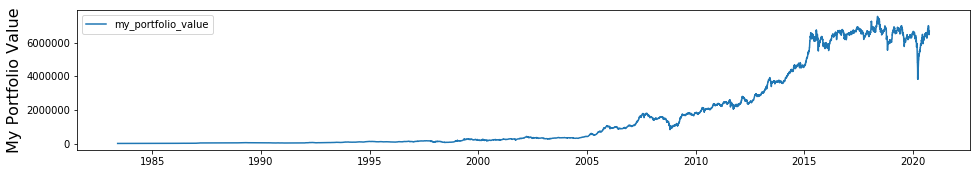

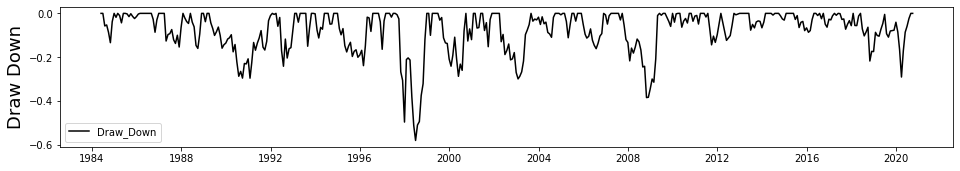

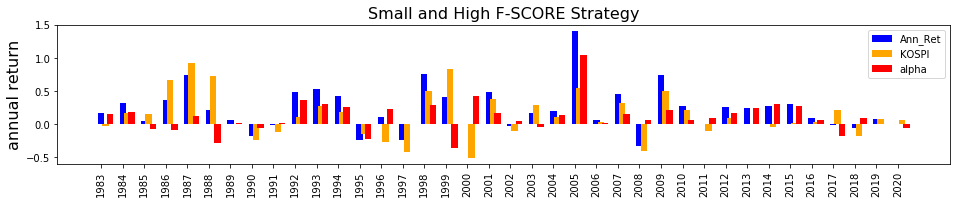

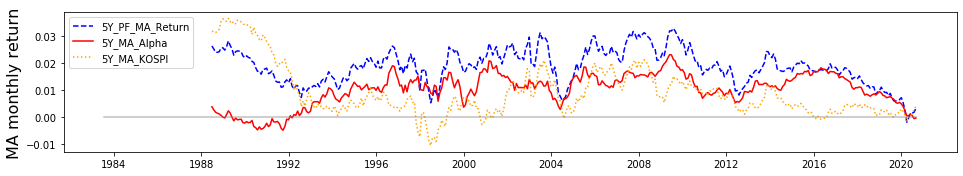

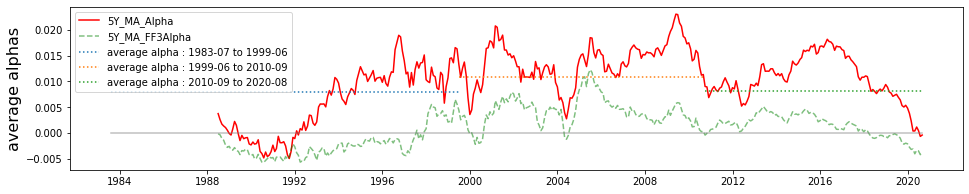

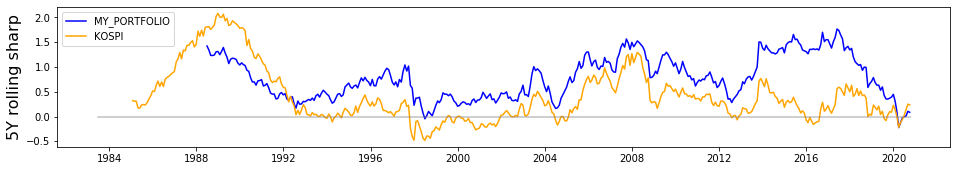

In [53]:
DF ,  FF3_Data, format1 , format2 , result_data = port_analyze(Z_SCORE[['Small_High']].dropna(), Created_Factor,date_lst = ['1999-06-30','2010-09-30'], MA_Year = 5, beta_freq_Y = 5, plotting = True,title = 'Small and High F-SCORE Strategy') 

In [54]:
result_data

,initial,final,CAGR,Stdev,MDD,Sharp_Ratio,Best_Year,Worst_Year,Mkt_Corr
1983-06-01 - 2020-09-30,10000,6679200,0.190174,0.288567,0.578121,0.659028,1.407221,-0.331617,0.711049
1983-06-01 - 1999-06-30,10000,262385,0.225139,0.346305,0.578121,0.650118,0.783064,-0.245583,0.721480
1999-06-30 - 2010-09-30,262385,2143921,0.205082,0.278100,0.383078,0.737439,1.407221,-0.331617,0.683952
2010-09-30 - 2020-09-30,2143921,6679200,0.120240,0.177806,0.289622,0.676242,0.300976,-0.060891,0.734292


In [78]:
KOSPI200_Mom = backtest(Momentum.KOSPI200_Momentum,(0,0.1),cleaned_data, cleaned_price, cleaned_mktvalue ,
             cleaned_kospiyn,delist_data, stop_data,'1983-06-30','2020-09-30' ,
             rebalance_freq = '1M',optimal_rebalance = False , equal_weight = True,
             initial_money = 10000, fee = 0.00, inkospi_check = True,
             last_day_rebalance = True, extreme_q = 0.02)[0]

1983-06-30 10000 17 거래정지 : 0 0.06 1.0
1983-07-31 10888 17 거래정지 : 0 0.06 1.0
1983-08-31 10477 16 거래정지 : 0 0.06 1.0
1983-09-30 10216 17 거래정지 : 0 0.06 1.0
1983-10-31 10787 17 거래정지 : 0 0.06 1.0
1983-11-30 10312 17 거래정지 : 0 0.06 1.0
1983-12-31 11062 17 거래정지 : 0 0.06 1.0
1984-01-31 11866 17 거래정지 : 0 0.06 1.0
1984-02-29 11738 17 거래정지 : 0 0.06 1.0
1984-03-31 11935 17 거래정지 : 0 0.06 1.0
1984-04-30 14314 17 거래정지 : 0 0.06 1.0
1984-05-31 14265 15 거래정지 : 0 0.07 1.0
1984-06-30 15061 17 거래정지 : 0 0.06 1.0
1984-07-31 13979 17 거래정지 : 0 0.06 1.0
1984-08-31 14423 16 거래정지 : 0 0.06 1.0
1984-09-30 13812 17 거래정지 : 0 0.06 1.0
1984-10-31 13218 17 거래정지 : 0 0.06 1.0
1984-11-30 13107 17 거래정지 : 0 0.06 1.0
1984-12-31 13548 17 거래정지 : 0 0.06 1.0
1985-01-31 13609 17 거래정지 : 0 0.06 1.0
1985-02-28 13764 17 거래정지 : 0 0.06 1.0
1985-03-31 13553 17 거래정지 : 0 0.06 1.0
1985-04-30 12782 17 거래정지 : 0 0.06 1.0
1985-05-31 13540 14 거래정지 : 0 0.07 1.0
1985-06-30 13572 17 거래정지 : 0 0.06 1.0
1985-07-31 13099 17 거래정지 : 0 0.06 1.0
1985-08-31 1

2002-01-31 41295 19 거래정지 : 0 0.05 1.0
2002-02-28 46365 19 거래정지 : 0 0.05 1.0
2002-03-31 54544 19 거래정지 : 0 0.05 1.0
2002-04-30 47239 19 거래정지 : 0 0.05 1.0
2002-05-31 43124 17 거래정지 : 0 0.06 1.0
2002-06-30 45466 19 거래정지 : 0 0.05 1.0
2002-07-31 45648 19 거래정지 : 0 0.05 1.0
2002-08-31 46009 19 거래정지 : 0 0.05 1.0
2002-09-30 39590 18 거래정지 : 1 0.05 1.0
2002-10-31 41507 19 거래정지 : 0 0.05 1.0
2002-11-30 46673 19 거래정지 : 0 0.05 1.0
2002-12-31 40229 19 거래정지 : 0 0.05 1.0
2003-01-31 38310 19 거래정지 : 0 0.05 1.0
2003-02-28 39519 19 거래정지 : 0 0.05 1.0
2003-03-31 38384 19 거래정지 : 0 0.05 1.0
2003-04-30 43755 19 거래정지 : 0 0.05 1.0
2003-05-31 48716 18 거래정지 : 0 0.06 1.0
2003-06-30 51409 19 거래정지 : 0 0.05 1.0
2003-07-31 53210 19 거래정지 : 0 0.05 1.0
2003-08-31 60758 19 거래정지 : 0 0.05 1.0
2003-09-30 57121 19 거래정지 : 0 0.05 1.0
2003-10-31 67913 19 거래정지 : 0 0.05 1.0
2003-11-30 74972 19 거래정지 : 0 0.05 1.0
2003-12-31 82560 19 거래정지 : 0 0.05 1.0
2004-01-31 78004 19 거래정지 : 0 0.05 1.0
2004-02-29 79347 18 거래정지 : 1 0.05 1.0
2004-03-31 7

2019-09-30 565652 19 거래정지 : 0 0.05 1.0
2019-10-31 539945 19 거래정지 : 0 0.05 1.0
2019-11-30 537717 19 거래정지 : 0 0.05 1.0
2019-12-31 557856 19 거래정지 : 0 0.05 1.0
2020-01-31 531673 19 거래정지 : 0 0.05 1.0
2020-02-29 483628 20 거래정지 : 0 0.05 1.0
2020-03-31 419633 20 거래정지 : 0 0.05 1.0
2020-04-30 478497 20 거래정지 : 0 0.05 1.0
2020-05-31 528272 20 거래정지 : 0 0.05 1.0
2020-06-30 606649 20 거래정지 : 0 0.05 1.0
2020-07-31 683222 20 거래정지 : 0 0.05 1.0
2020-08-31 722946 20 거래정지 : 0 0.05 1.0


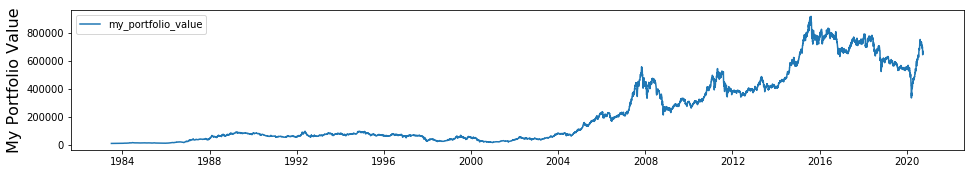

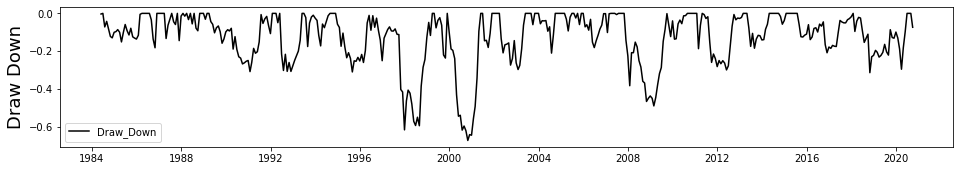

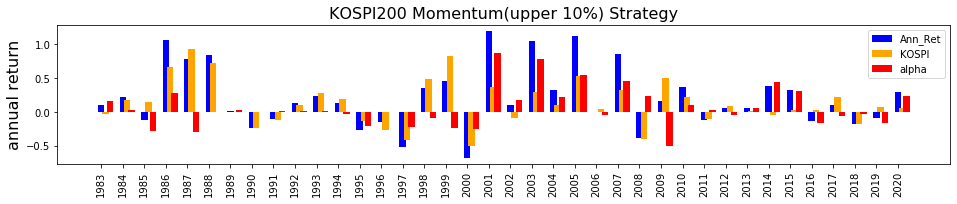

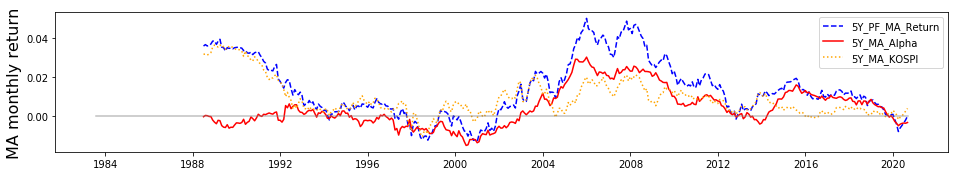

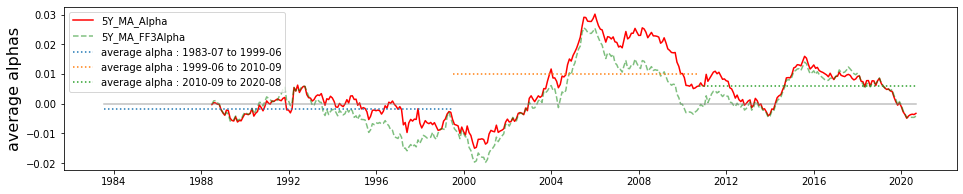

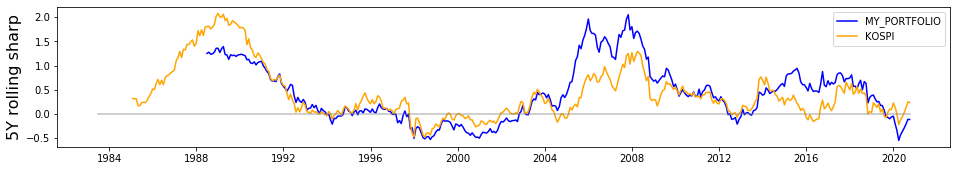

In [79]:
DF ,  FF3_Data, format1 , format2 , result_data = port_analyze(KOSPI200_Mom, Created_Factor,date_lst = ['1999-06-30','2010-09-30'], MA_Year = 5, beta_freq_Y = 5, plotting = True,title = 'KOSPI200 Momentum(upper 10%) Strategy') 

In [80]:
result_data 

,initial,final,CAGR,Stdev,MDD,Sharp_Ratio,Best_Year,Worst_Year,Mkt_Corr
1983-06-30 - 2020-09-30,10000,669730,0.119383,0.337013,0.673517,0.354239,1.201802,-0.681271,0.754200
1983-06-30 - 1999-06-30,10000,55590,0.113090,0.358419,0.617428,0.315525,1.064009,-0.525771,0.743428
1999-06-30 - 2010-09-30,55590,367153,0.182522,0.381156,0.673517,0.478863,1.201802,-0.681271,0.810140
2010-09-30 - 2020-09-30,367153,669730,0.061901,0.234229,0.314341,0.264273,0.390678,-0.175625,0.692397


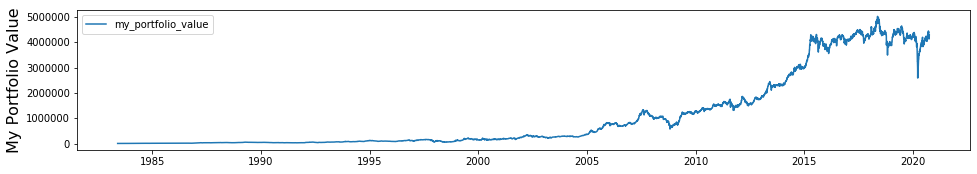

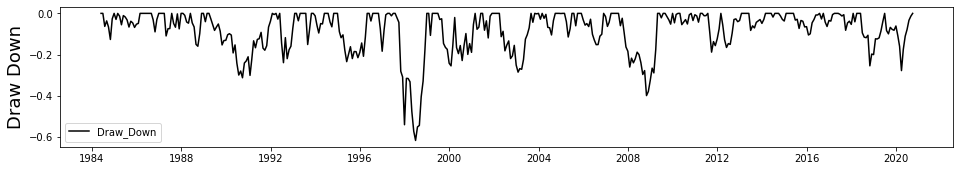

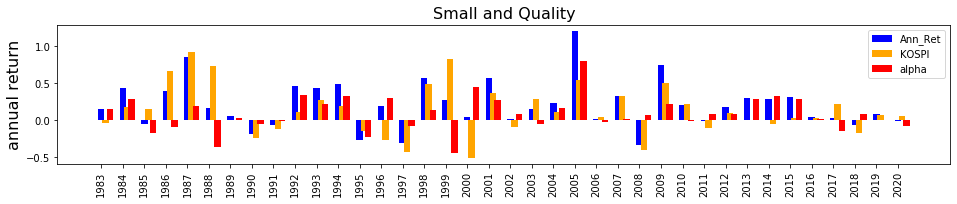

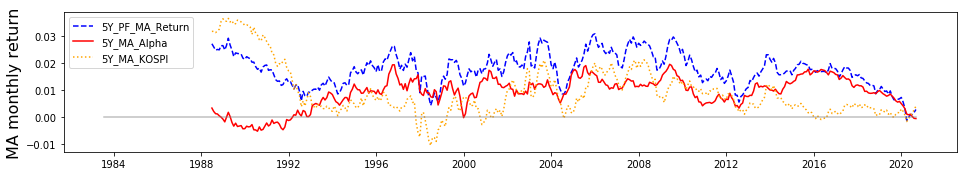

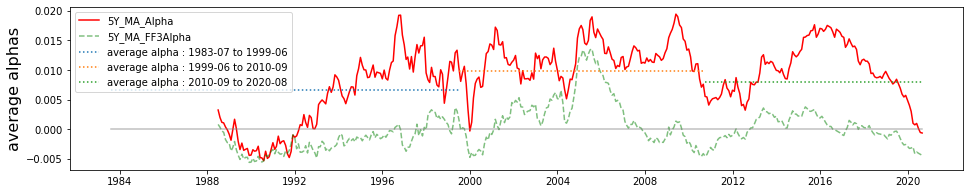

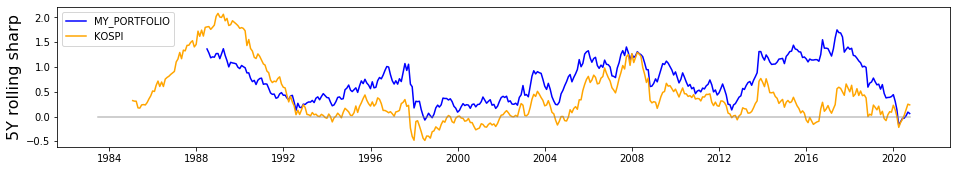

In [37]:
DF ,  FF3_Data, format1 , format2 , result_data = port_analyze(QBLEND[['Small_High']].dropna(), Created_Factor,date_lst = ['1999-06-30','2010-09-30'], MA_Year = 5, beta_freq_Y = 5, plotting = True,title = 'Small and Quality') 

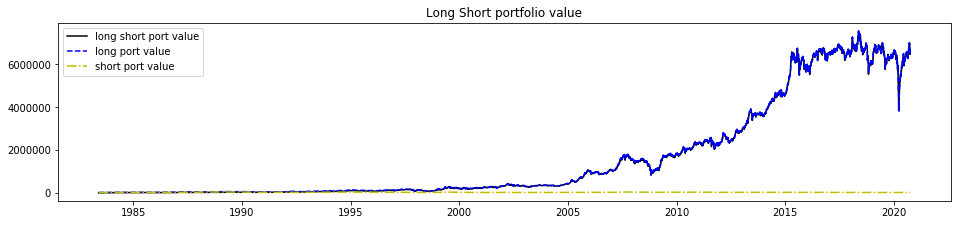

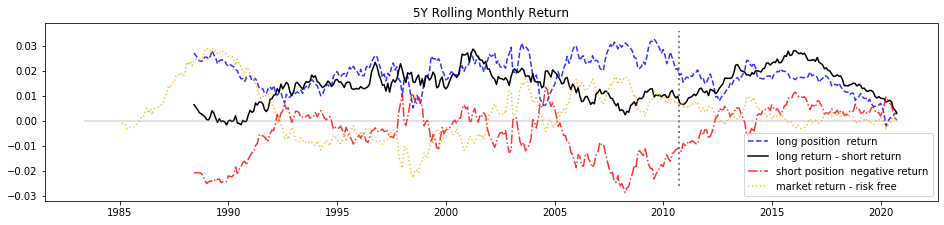

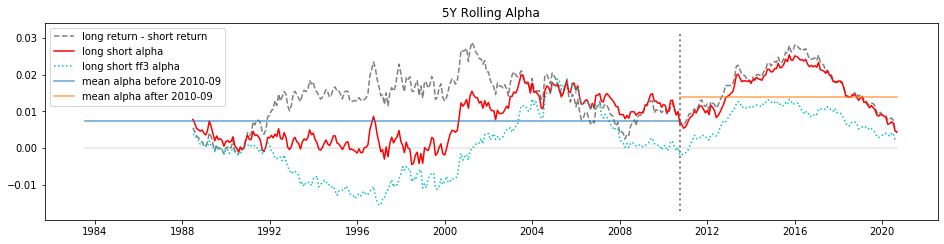

In [81]:
my_pf_value,A_minus_B_index, df, FF3_Data, format1, format2 = Long_Short_Profile(Z_SCORE[['Small_High']], Z_SCORE[['Big_Low']] , Created_Factor, date_lst = ['2010-09-30'], beta_freq_Y = 5, MA_Year = 5, stats_data = ['mean','T-value'], plotting = True,title_name = '')

In [82]:
format2

1983-07 - 2010-09  2010-09 - 2020-08
return        mean              0.012679           0.015061
              T-value           3.227594           3.998250
alpha         mean              0.006972           0.013895
              T-value           1.917160           3.892674
3factor_alpha mean              0.002352           0.007826
              T-value           0.784323           3.021417